# Pronostico 2022 - 2026 Maximos Potencia Aparente ET SAN FRANCISCO

NOTAS:
Se dispone de los datos del SITEC ordenados cada 15 minutos por Estacion
13/10/2021 12:55

1. La demanda en 13 KV del SITEC es la que soportan los trafos de la ET ???? 

2. Leer la tabla 3 de Transformadores y colocar ese pronostico como alternativo

3. Tengo que arreglar y mejorar los graficos con Matplotlib

INFORME
 
1. Al informe se lo presento en word o lo presento con nbviewer

2. Si lo presento con word, tengo que pasar Tablaxls a Excel

## Seteo Inicial

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Viernes 8 Octubre 2021 17:43:11 

@author: Daniel Busso
"""

# Plantilla de Pre Procesado

# Cómo importar las librerías
import numpy    as np
import pandas   as pd
import datetime as dt
import os

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error

#from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import time_series_spliter
#from skforecast.model_selection import cv_forecaster
#from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection import backtesting_forecaster_intervals

In [39]:
# Configuracion Pandas

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', '{:.2f}'.format)

## Lectura de Archivos Anuales por EETT 
Lectura y creacion del index DateTime para tratar el DataFrame como una Serie de Tiempo

In [5]:
def conversion_2400(fecha):
    if fecha[11:13] != '24':
        return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M')

    fecha = fecha[0:11] + '00:' + fecha[14:]
    return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M') + dt.timedelta(days=1)

In [6]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sanfrancisco

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
i = 0
for nombre_completo in archivos:
    if (i == 0) :
        dfconca = pd.read_fwf(nombre_completo, header=0, decimal=',')
    else:
        dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
        dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    i = i + 1

In [7]:
#
# BORRAMOS COLUMNAS NO USADAS
#

del dfconca['Ampere']
del dfconca['KVolt']

In [8]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)
serie     = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
serie_ord = serie.sort_index()

datos = serie_ord.copy()
datos

Fecha   Hora    MW  MVAR   MVA
Fecha_Hora                                              
2010-01-01 00:15:00  01/01/2010  00:15 15.80 7.13  17.33
2010-01-01 00:30:00  01/01/2010  00:30 15.63 6.82  17.05
2010-01-01 00:45:00  01/01/2010  00:45 15.49 6.80  16.91
2010-01-01 01:00:00  01/01/2010  01:00 15.55 6.81  16.98
2010-01-01 01:15:00  01/01/2010  01:15 15.50 6.82  16.93
...                         ...    ...   ...  ...    ...
2020-12-31 22:45:00  31/12/2020  22:45 16.49 4.07  16.98
2020-12-31 23:00:00  31/12/2020  23:00 16.32 3.98  16.80
2020-12-31 23:15:00  31/12/2020  23:15 16.21 3.89  16.67
2020-12-31 23:30:00  31/12/2020  23:30 16.22 3.99  16.70
2020-12-31 23:45:00  31/12/2020  23:45 16.10 3.96  16.58

[376585 rows x 5 columns]

### Chequeo si hay Registros / Filas Faltantes
Si dife distinto de cero, significa que faltan registros/filas en los datos del SITEC

NOTA: Por el momento, no vamos a imputar estos Datos Faltantes

In [9]:
#dti2 = pd.date_range(start='2017-01-01 00:15:00', end='2018-01-01 00:00:00', freq="15min")
indice = pd.date_range(start=datos.index[0], end=datos.index[-1], freq="15min")
dife   = indice.difference(datos.index)
dife

DatetimeIndex(['2010-08-14 00:00:00', '2010-11-10 00:15:00',
               '2010-11-10 00:30:00', '2010-11-10 00:45:00',
               '2010-11-10 01:00:00', '2010-11-10 01:15:00',
               '2010-11-10 01:30:00', '2010-11-10 01:45:00',
               '2010-11-10 02:00:00', '2010-11-10 02:15:00',
               ...
               '2020-12-28 04:45:00', '2020-12-28 05:00:00',
               '2020-12-28 05:15:00', '2020-12-28 05:30:00',
               '2020-12-28 05:45:00', '2020-12-28 06:00:00',
               '2020-12-28 06:15:00', '2020-12-28 06:30:00',
               '2020-12-28 06:45:00', '2020-12-28 07:00:00'],
              dtype='datetime64[ns]', length=9142, freq=None)

In [10]:
if dife.empty == False:
    print('Faltan algunas Mediciones: ', len(dife), '% Incompletas= ', (len(dife)/len(indice)*100), '% Completas= ', \
          (((len(indice)-len(dife))/len(indice))*100))
else:
    print('Mediciones Completas: ', (((len(indice)-len(dife))/len(indice))*100))

Faltan algunas Mediciones:  9142 % Incompletas=  2.37007002361774 % Completas=  97.62992997638226


In [11]:
#datos2 = datos.drop(['Fecha', 'Hora'], axis=1)
#data.drop(['Fecha', 'Hora', 'Ampere', 'KVolt'], axis=1)
#datos2.iloc[0:100, :]

## Depuracion de Datos

### Graficas Anuales

In [12]:
# GRAFICA ANUAL X SEMANA PARA TODOS LOS ANIOS

def Grafica_Todos_Anios_xSemana():
    plt.style.use('fivethirtyeight')
    z = datos.loc[:, 'MVA'].resample('W').max()
    x = z.index

    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    grafico.plot(x, z, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE SEMANAL TODOS LOS AÑOS")  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Todos_Anios_xSemana.png")

In [13]:
# Grafica anual de la Potencia Aparente cada 15 minutos

def Grafica_Anual_15min(anio):
    plt.style.use('fivethirtyeight')
    y = datos.loc[anio:anio, 'MVA']
    x = y.index
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(x, y, lw=1, label='Potencia Aparente')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE CADA 15 MINUTOS " + anio)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_15min_"+anio+".png")

In [14]:
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_Anual_xDia(anio):
    plt.style.use('fivethirtyeight')
    y = datos.loc[anio:anio, 'MVA'].resample('D').max()
    x = y.index
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + anio)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

In [15]:
# Grafica del Pico Maximo Potencia Aparente x SEMANA

def Grafica_Anual_xSemana(anio):
    plt.style.use('fivethirtyeight')
    y = datos.loc[anio:anio, 'MVA'].resample('W').max()
    x = y.index

    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE SEMANAL " + anio)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xSemana_"+anio+".png")

### Graficas del Pico Maximo Anual Potencia Aparente 

In [16]:
# Tengo que calcular indice_max - 12 horas y indice_max + 12 horas para luego graficarlo

def Grafica_Pico_Anual(anio):
    plt.style.use('classic')
    
    indice_max = datos.loc[anio:anio, 'MVA'].idxmax()
    delta = pd.Timedelta('12 hours')
    indice_mas12   = indice_max + delta
    indice_menos12 = indice_max - delta
    
    maximo = datos.loc[indice_menos12:indice_mas12, 'MVA'].max()

    # GRAFICA DEL PICO MAXIMO POTENCIA APARENTE (CADA 15 MINUTOS) VENTANA 12 hs ANTES y 12 hs DESPUES
    y = datos.loc[indice_menos12 : indice_mas12, 'MVA']
    x = y.index

    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(10, 5))
    
    Rotulo = 'Pico: ' + str(indice_max) + ' ' + str(maximo)
    ax.plot(x, y, lw=1, label=Rotulo, marker='o')
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='blue', alpha=1, linewidth=1, ls='-')
    ax.grid(b=True, which='minor', color='beige', alpha=1, linewidth=1)
    # Major Tick Label
    # Minor Tick Label
    plt.xticks(fontsize=15, rotation=90)

    ax.set_xlabel('[ Horas ]', fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('[ MVA ]', fontsize=15)  # Add a y-label to the axes.
    ax.set_title("PICO MAXIMO POTENCIA APARENTE " + anio)  # Add a title to the axes.
    ax.legend(loc='lower left')  # Add a legend.
    #fig.savefig("Pico_Anual_"+anio+".png")
    
    #print(indice_menos12)
    print(indice_max, datos.loc[indice_menos12:indice_mas12, 'MW'].max(), datos.loc[indice_menos12:indice_mas12, 'MVA'].max())
    #print(indice_mas12)
    #maximo = datos.loc[indice_max:indice_max, 'MVA']
    #print(maximo[0])


In [17]:
archivos

[WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2010_1201.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2011_1200.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2012_1159.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2013_1157.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2014_1156.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2015_1154.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2016_1152.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2017_1151.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2018_1150.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2019_1150.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/

2010-01-05 14:00:00 36.24 37.32
2011-12-20 13:30:00 39.13 40.2
2012-02-16 14:00:00 42.13 43.18
2013-12-26 15:00:00 41.97 42.7
2014-01-23 14:00:00 48.77 49.73
2015-03-11 14:00:00 44.64 46.34
2016-02-12 13:15:00 45.98 46.79
2017-01-27 09:30:00 12.99 75.78
2018-02-07 13:45:00 46.22 46.35
2019-02-22 14:15:00 45.63 45.77
2020-10-11 05:00:00 46.83 73.79


<Figure size 432x288 with 0 Axes>

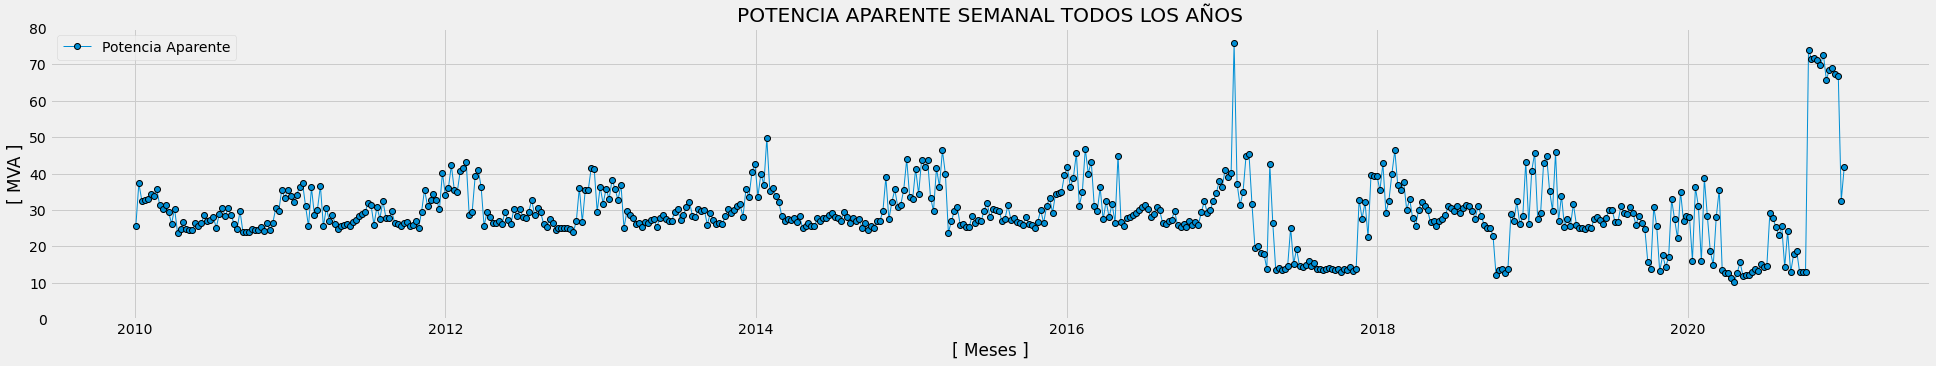

<Figure size 432x288 with 0 Axes>

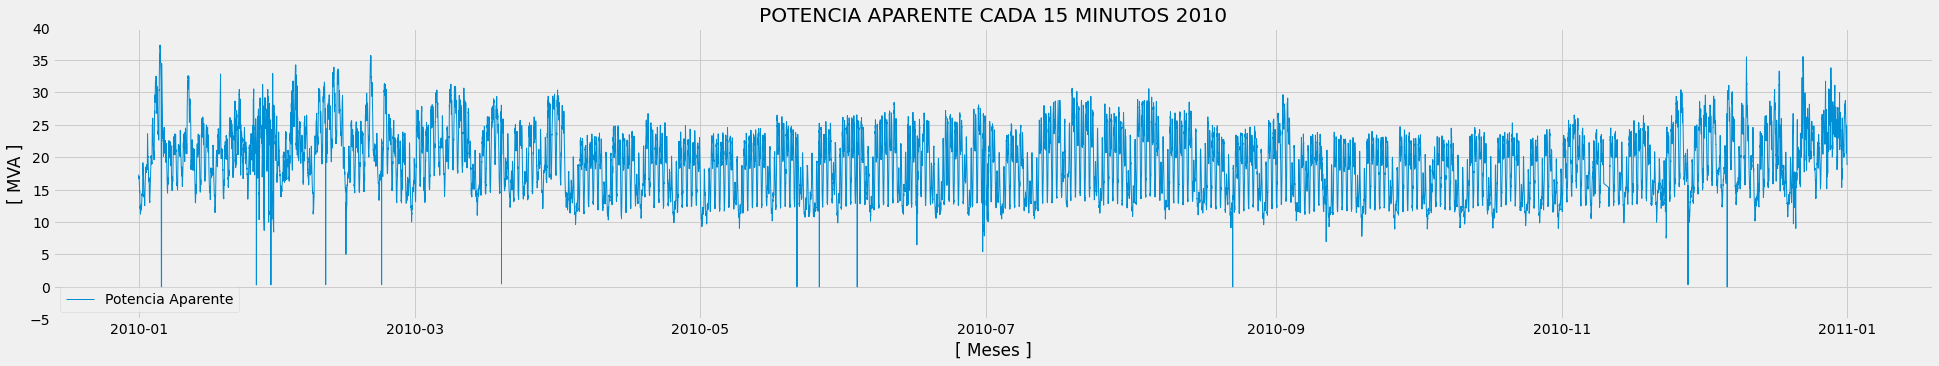

<Figure size 432x288 with 0 Axes>

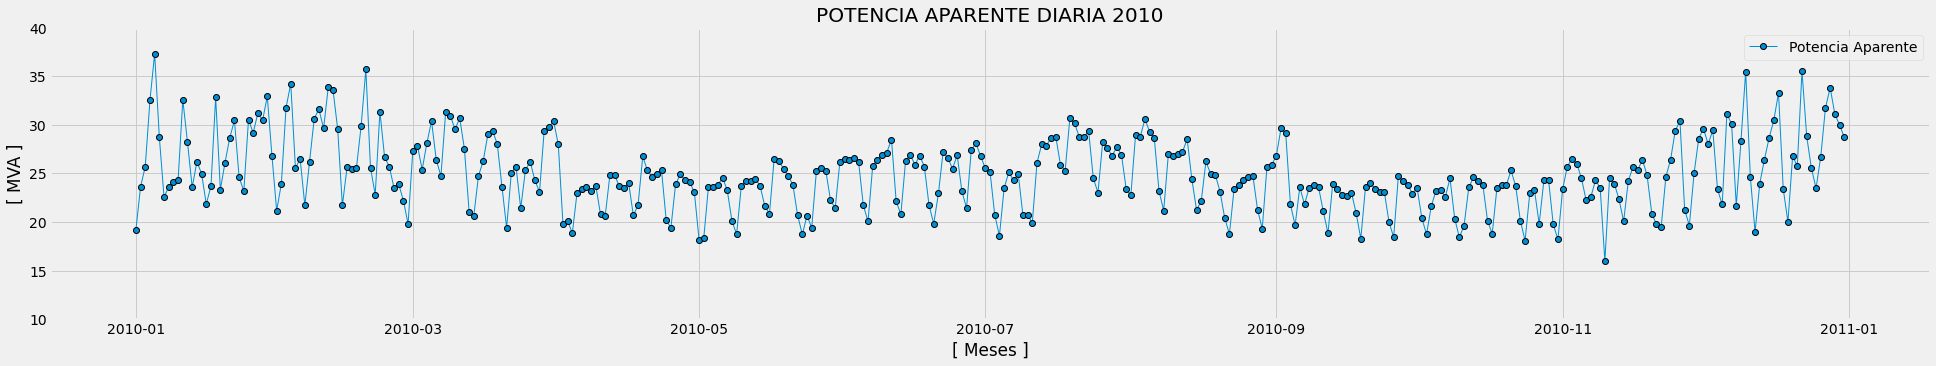

<Figure size 432x288 with 0 Axes>

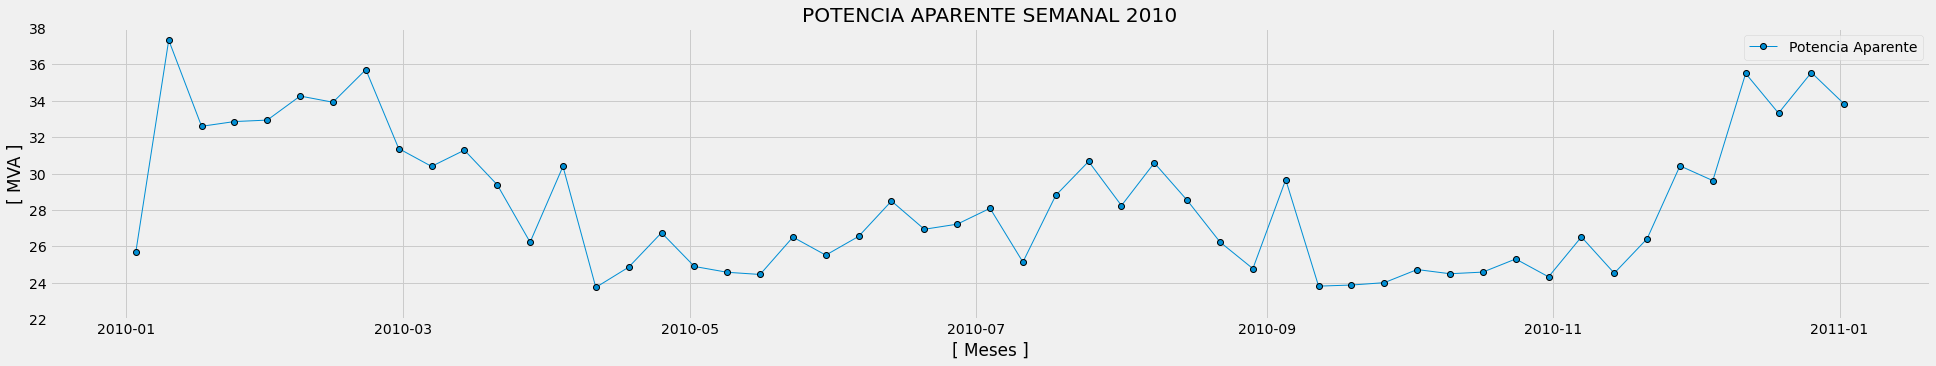

<Figure size 640x480 with 0 Axes>

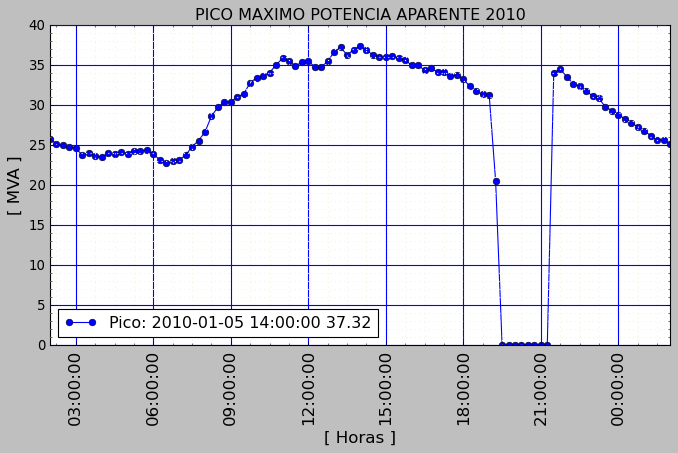

<Figure size 640x480 with 0 Axes>

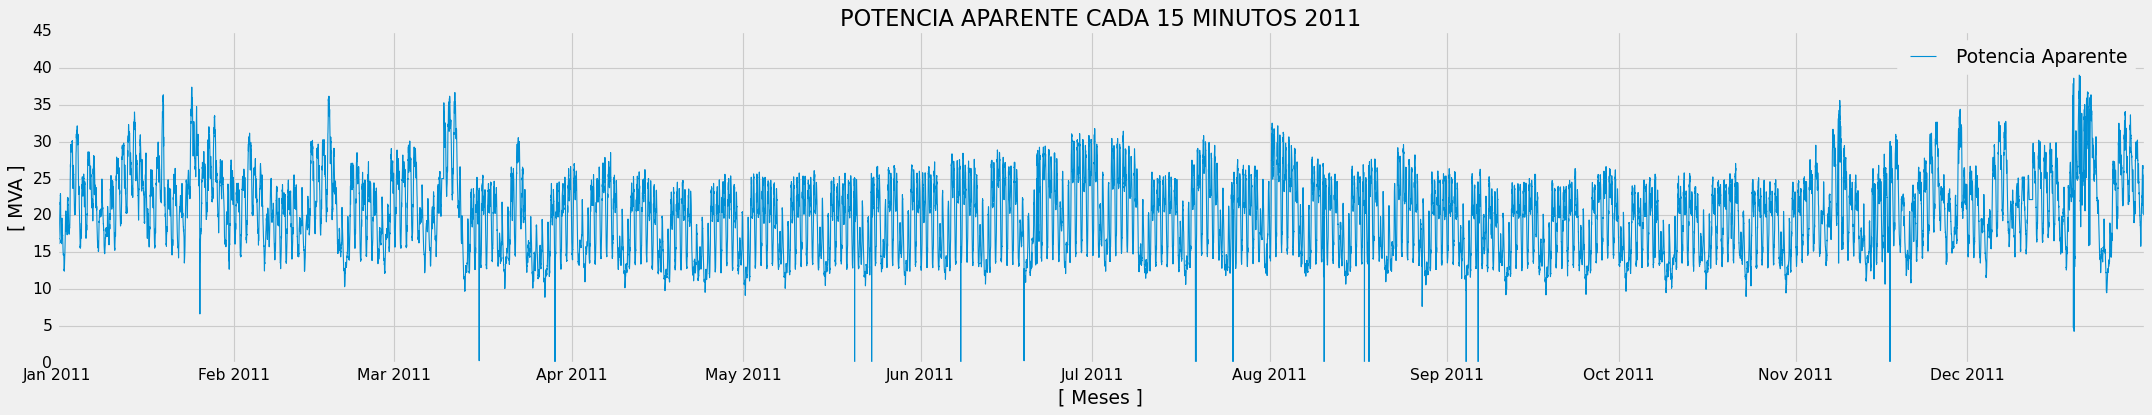

<Figure size 640x480 with 0 Axes>

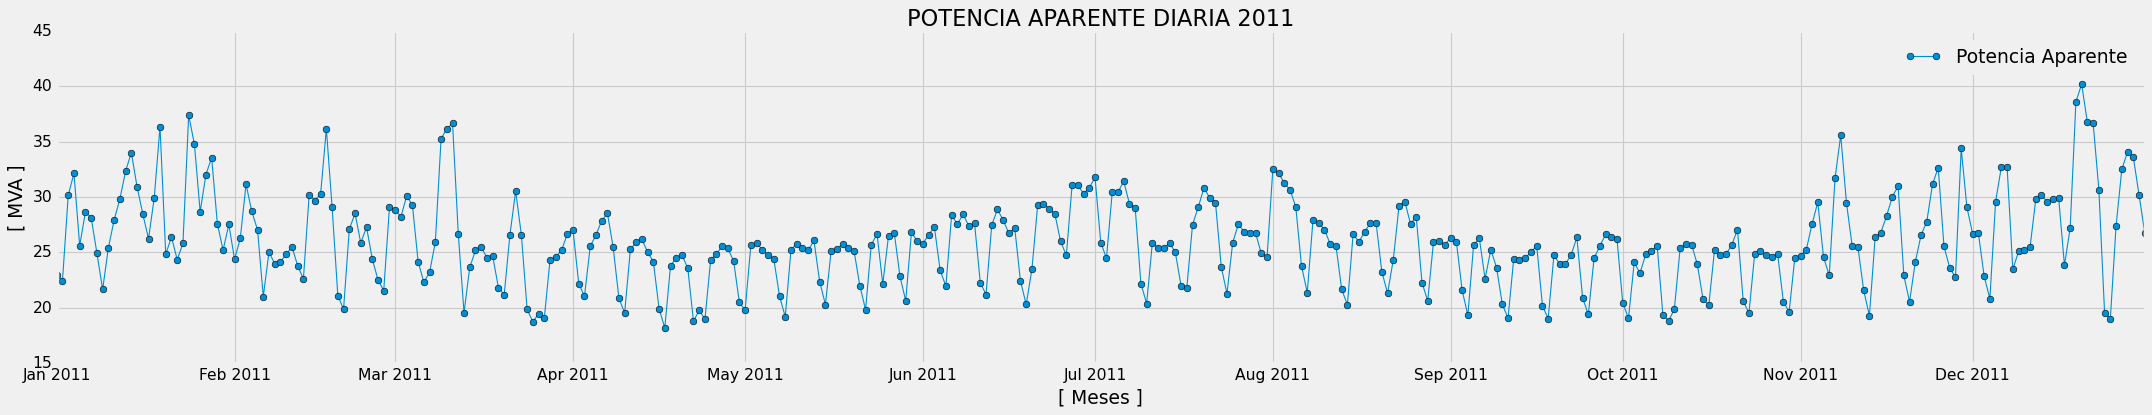

<Figure size 640x480 with 0 Axes>

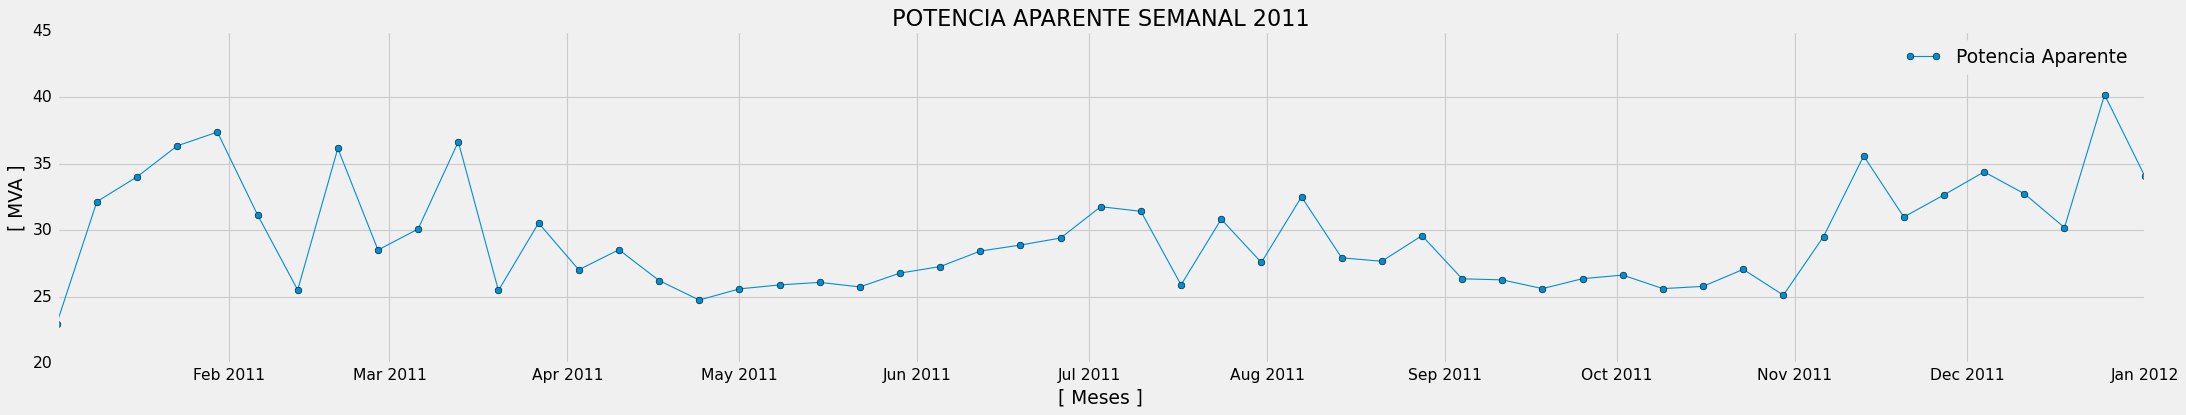

<Figure size 640x480 with 0 Axes>

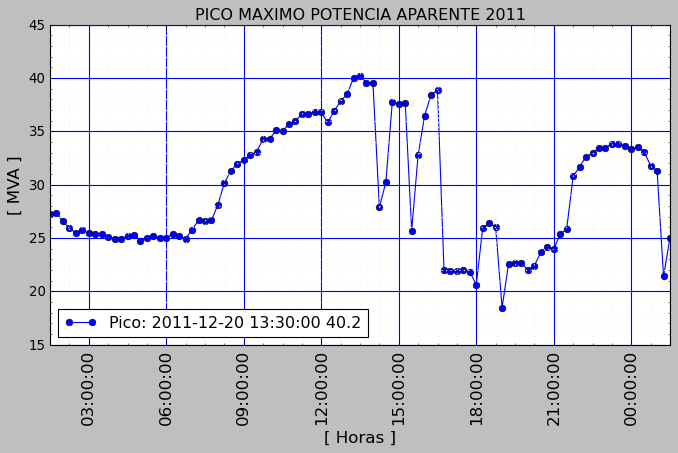

<Figure size 640x480 with 0 Axes>

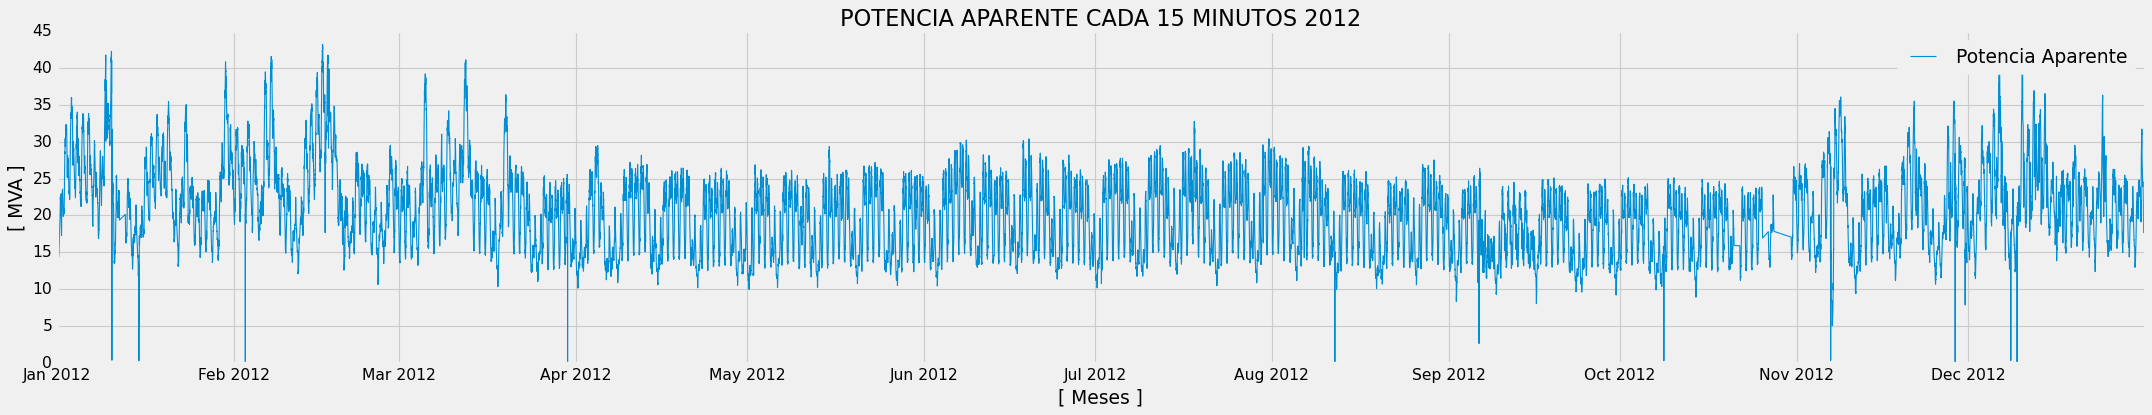

<Figure size 640x480 with 0 Axes>

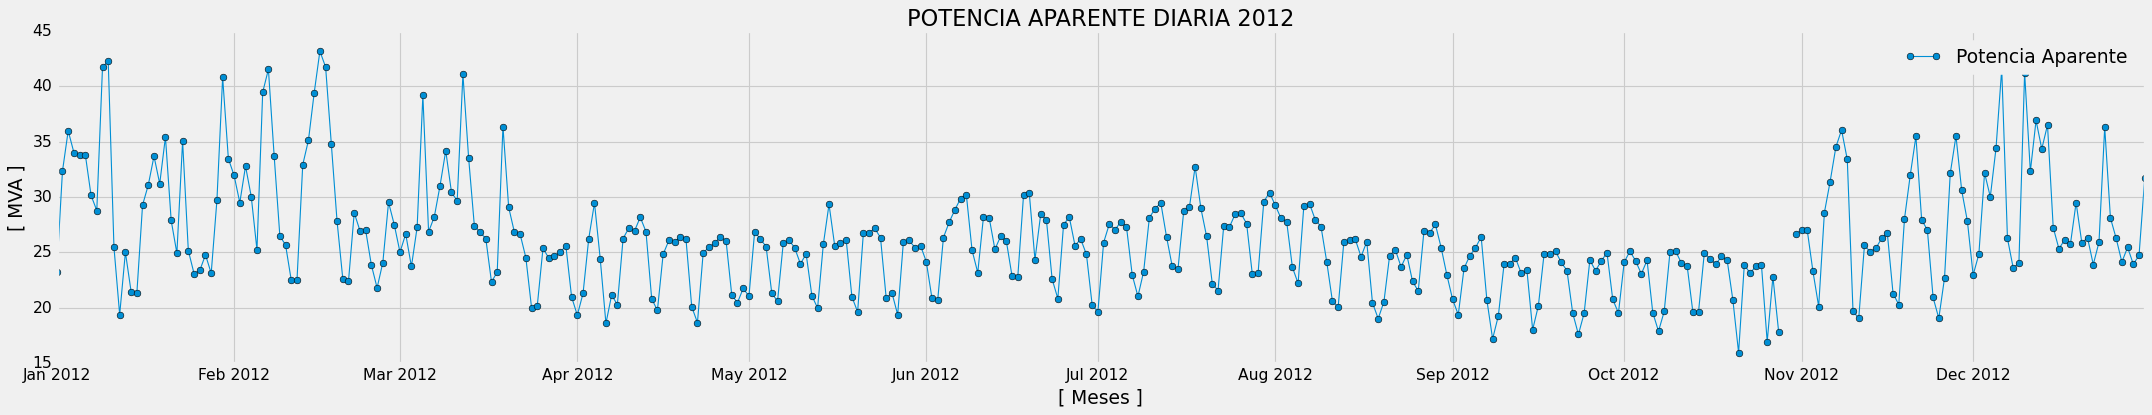

<Figure size 640x480 with 0 Axes>

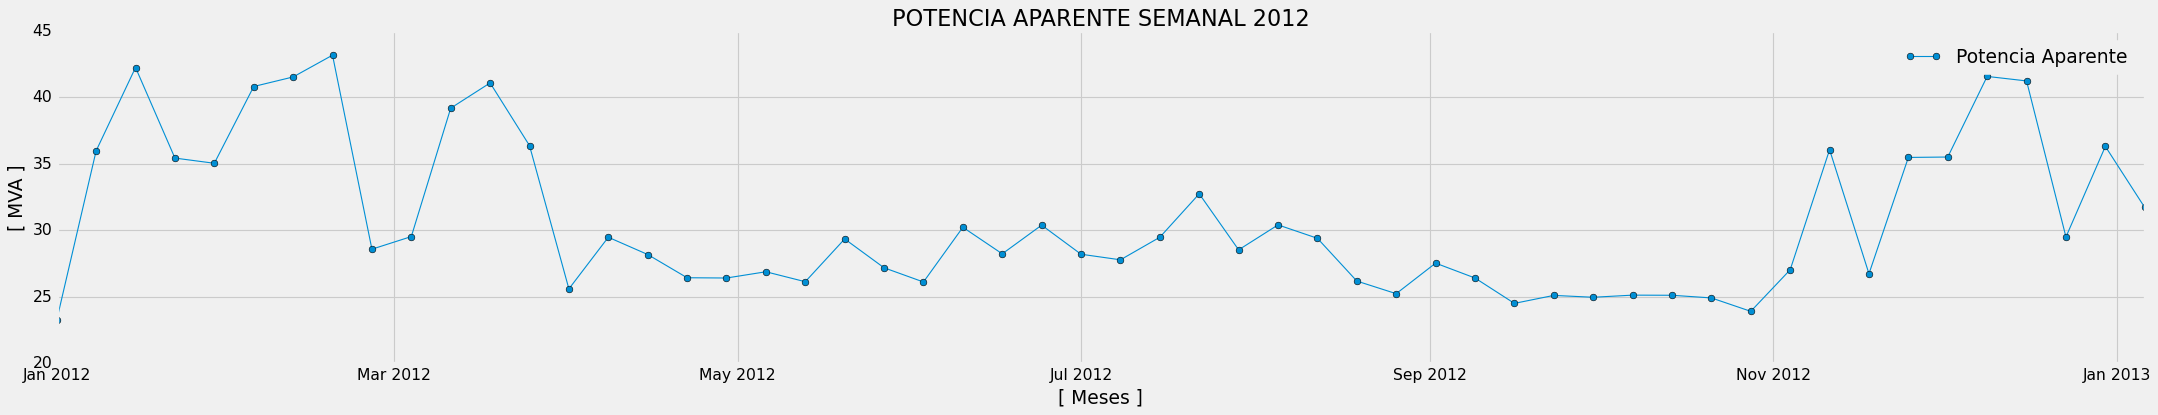

<Figure size 640x480 with 0 Axes>

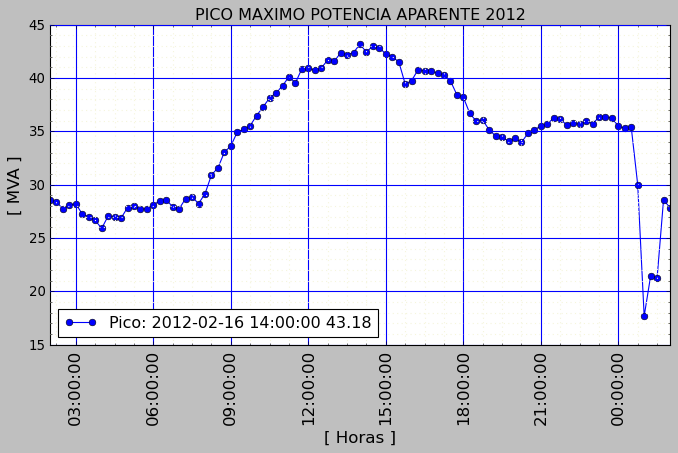

<Figure size 640x480 with 0 Axes>

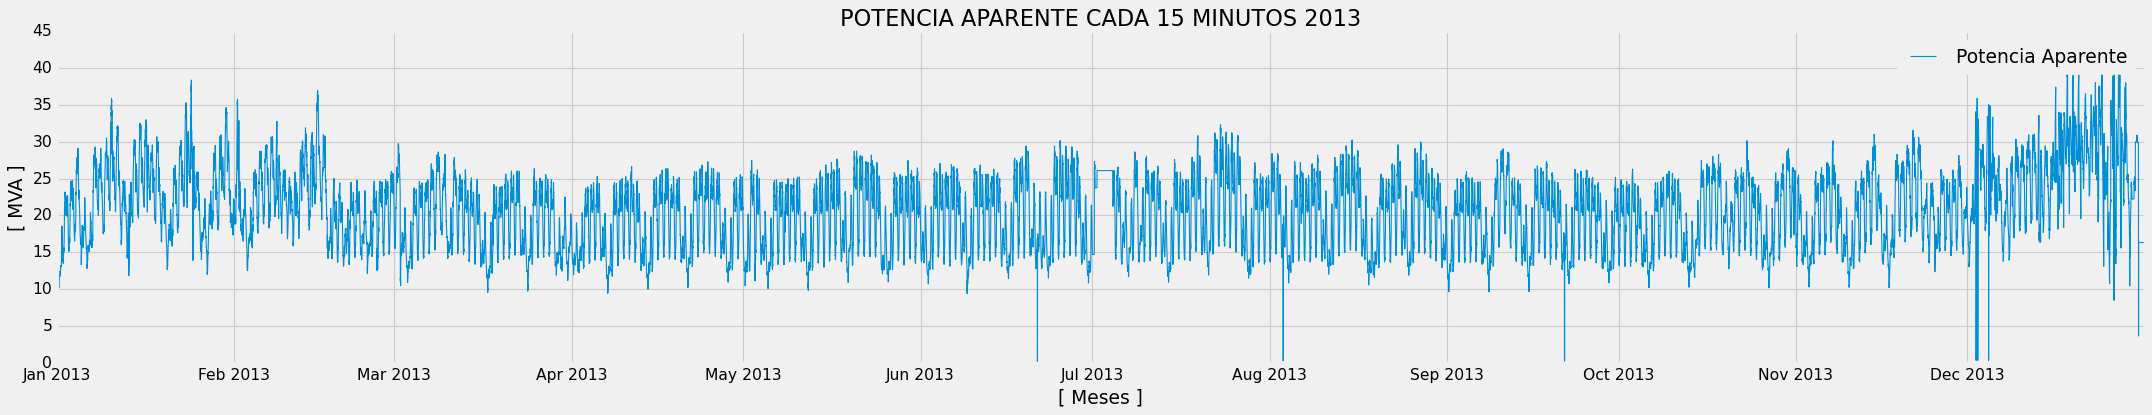

<Figure size 640x480 with 0 Axes>

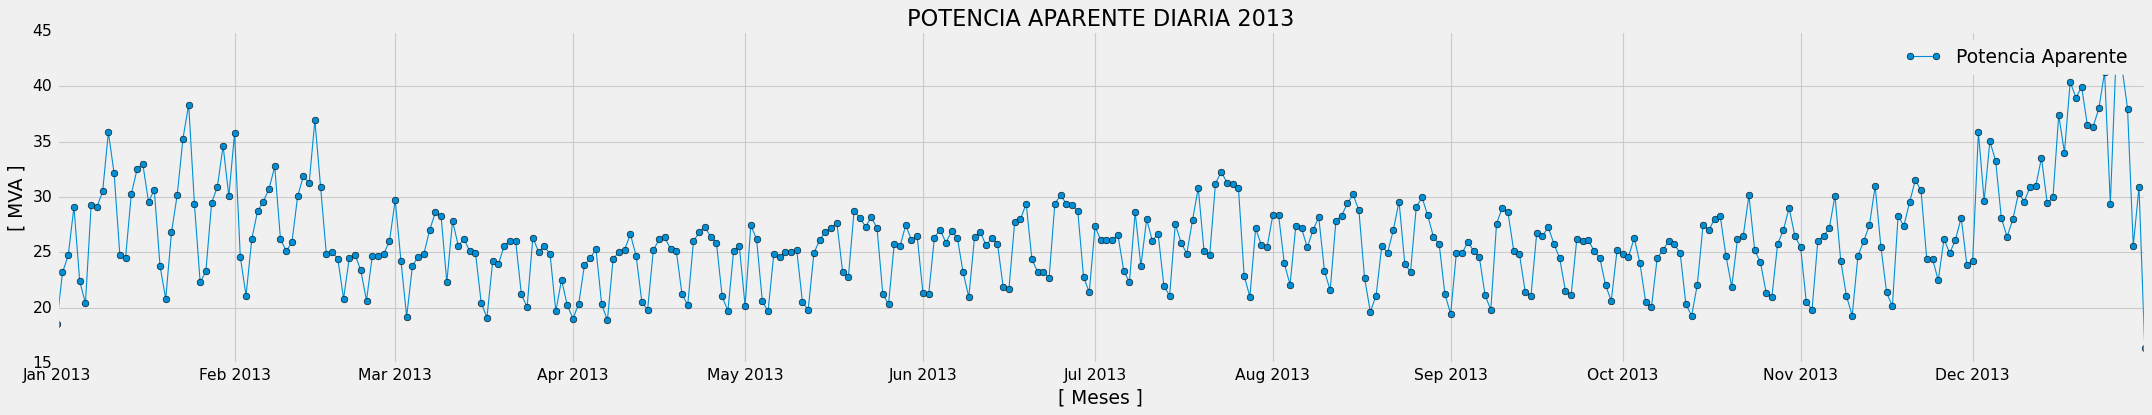

<Figure size 640x480 with 0 Axes>

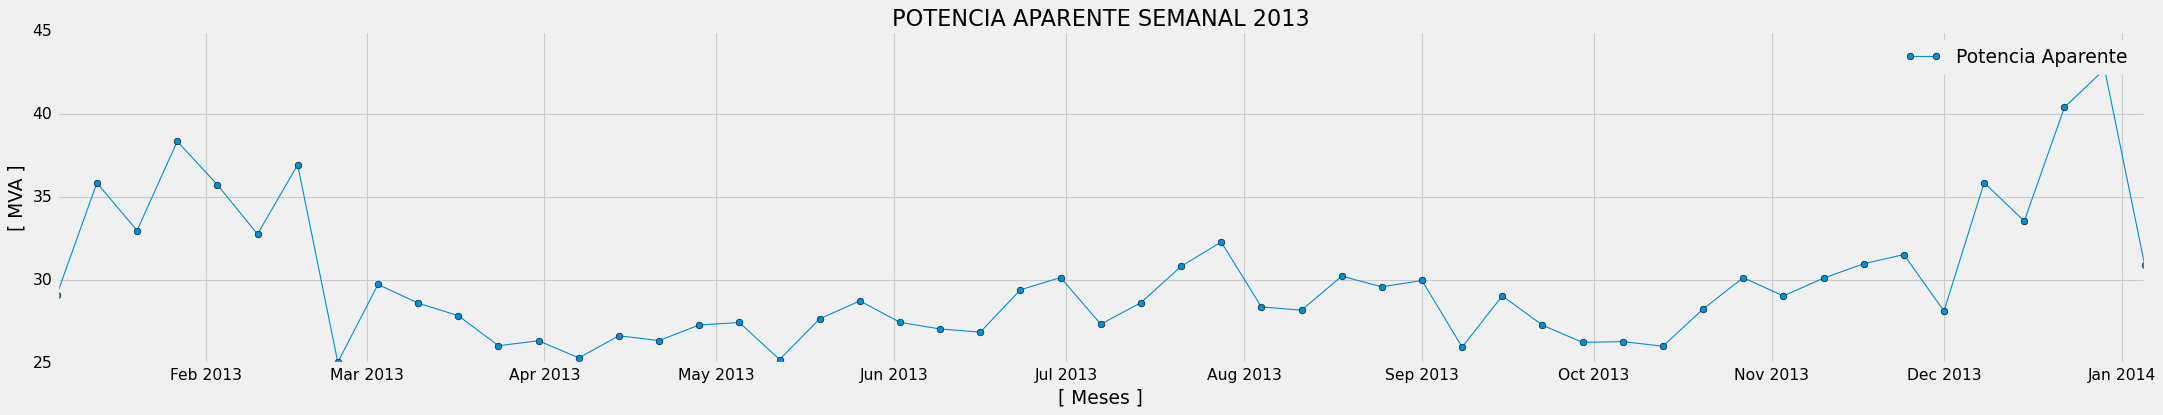

<Figure size 640x480 with 0 Axes>

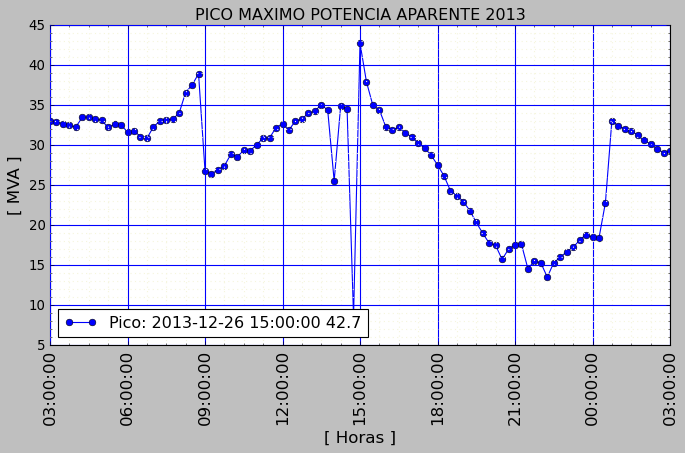

<Figure size 640x480 with 0 Axes>

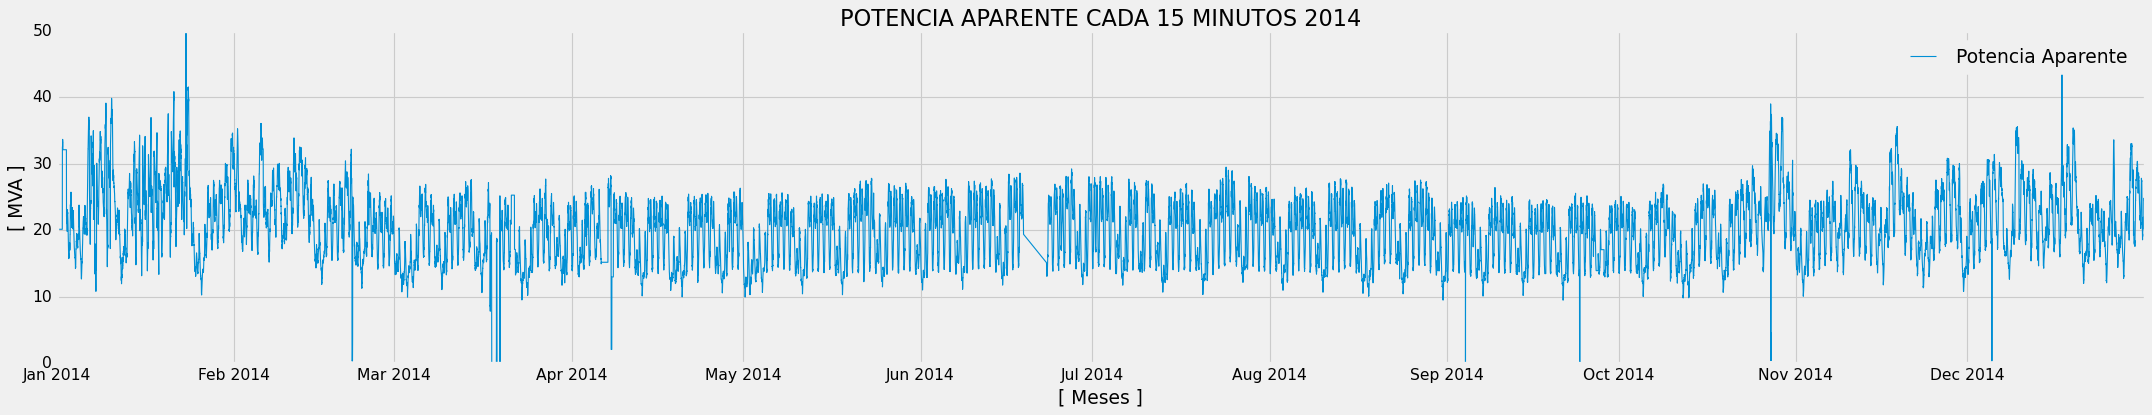

<Figure size 640x480 with 0 Axes>

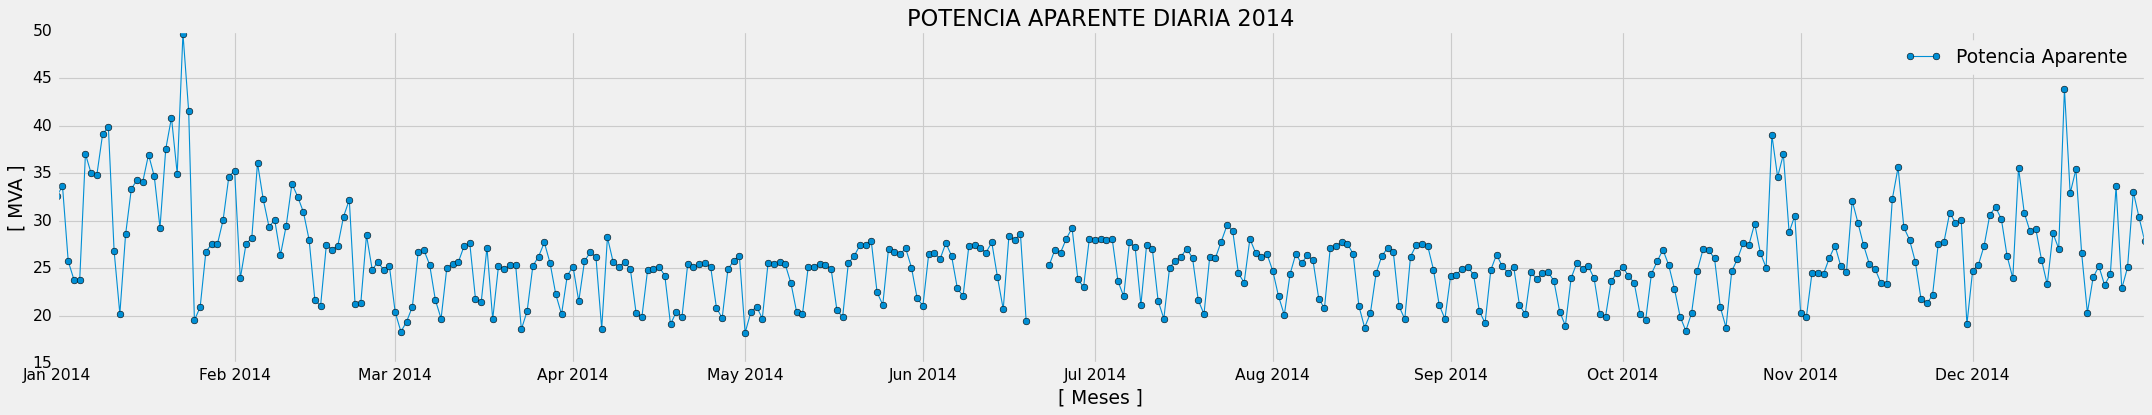

<Figure size 640x480 with 0 Axes>

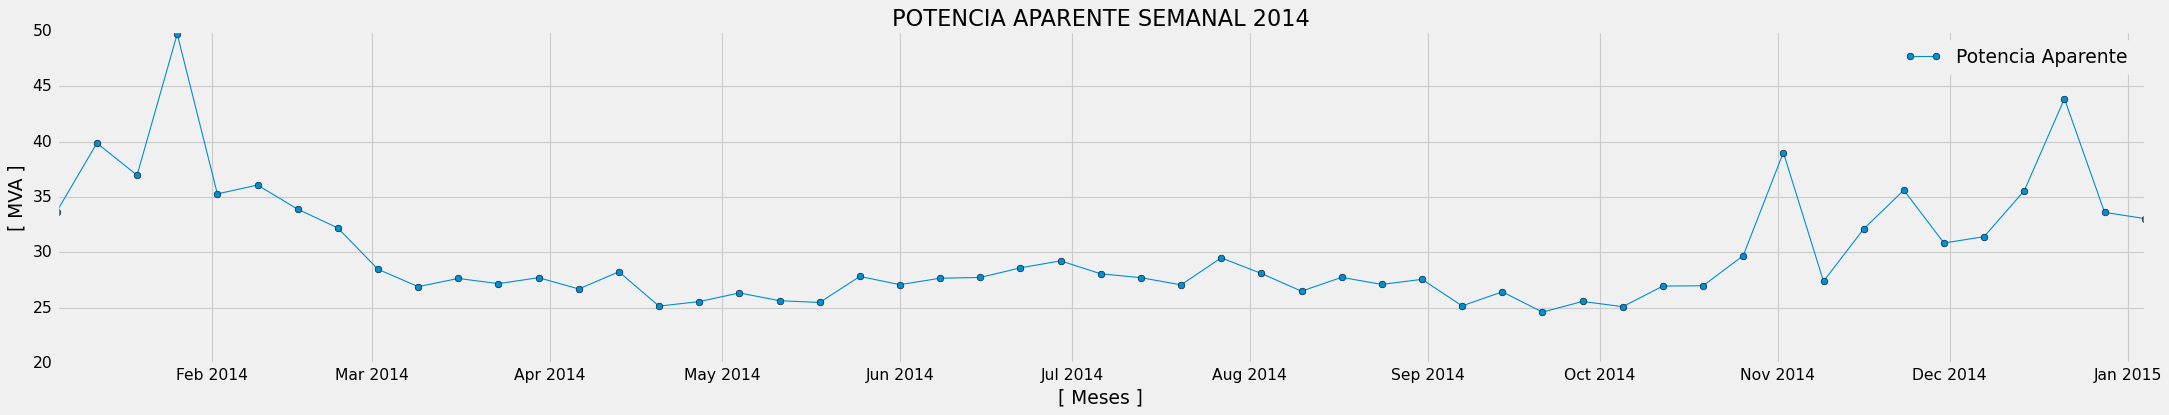

<Figure size 640x480 with 0 Axes>

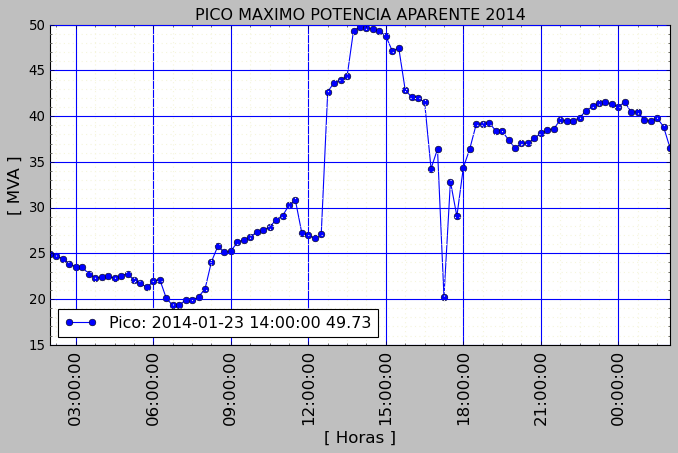

<Figure size 640x480 with 0 Axes>

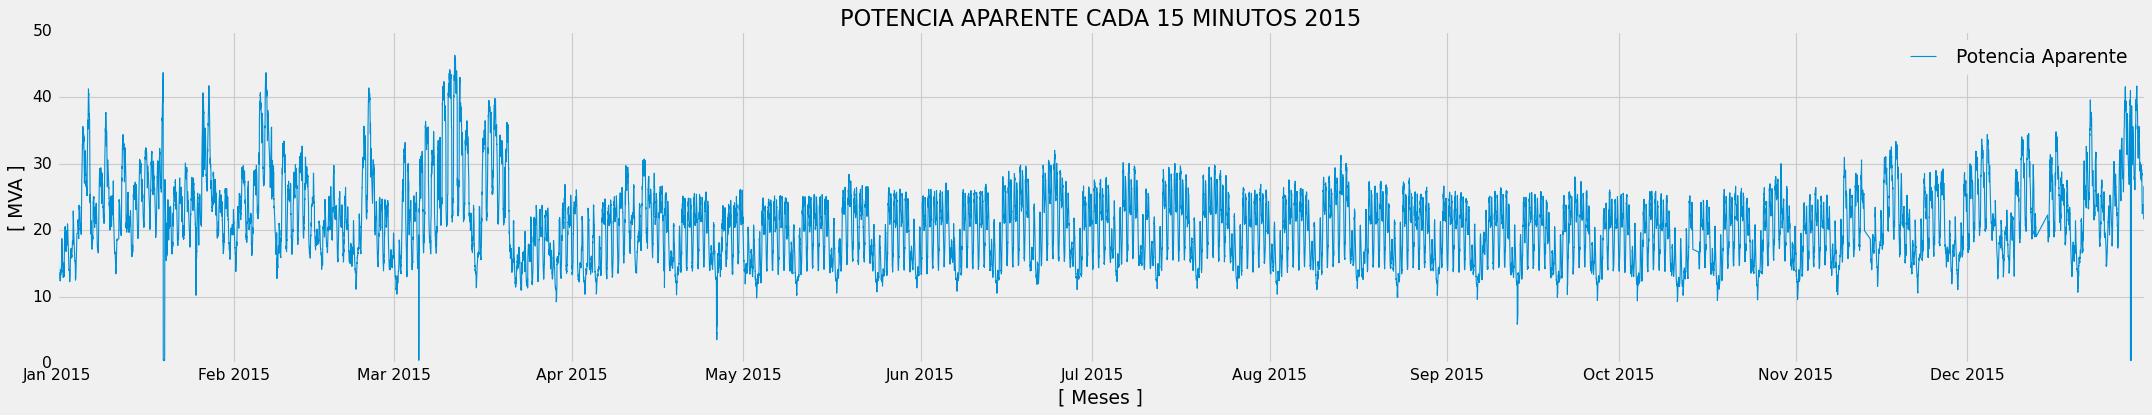

<Figure size 640x480 with 0 Axes>

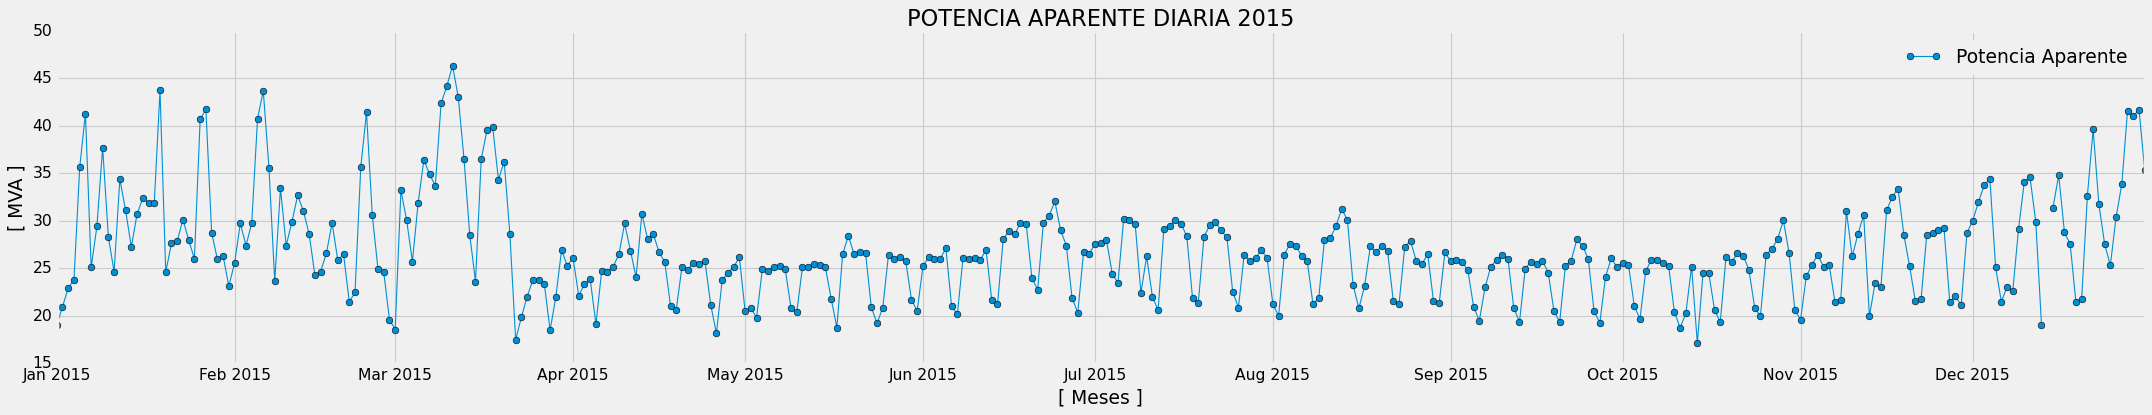

<Figure size 640x480 with 0 Axes>

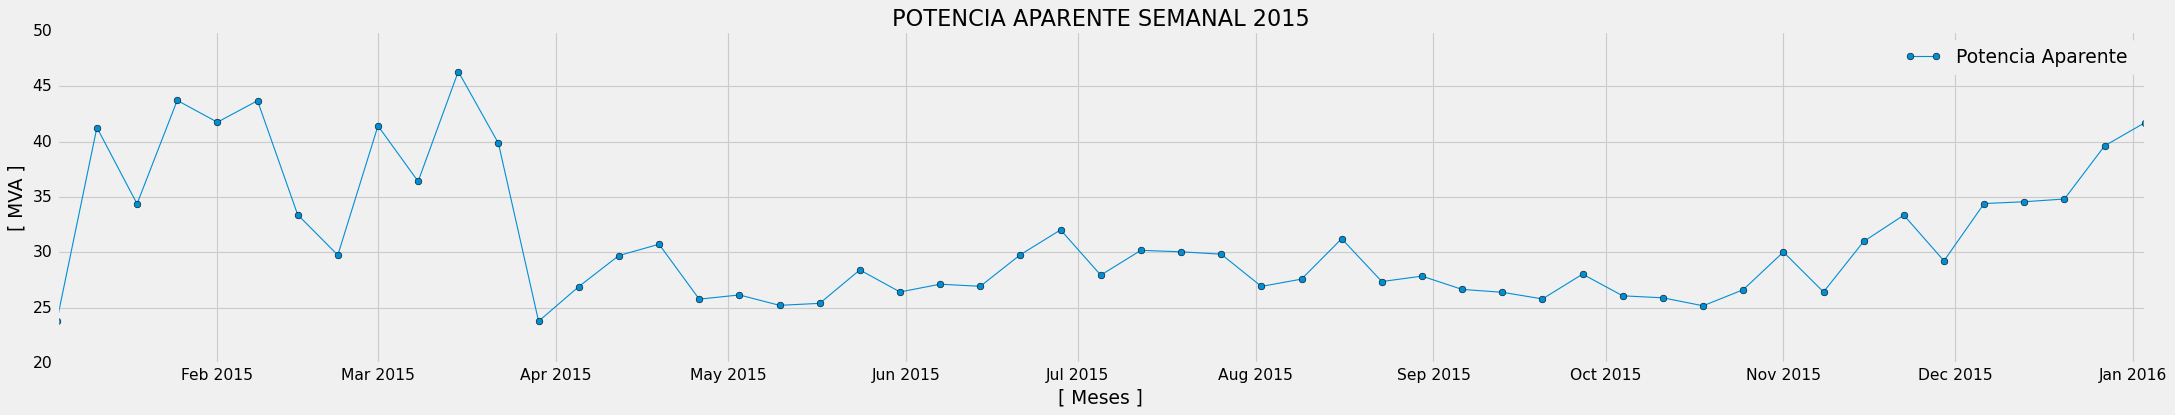

<Figure size 640x480 with 0 Axes>

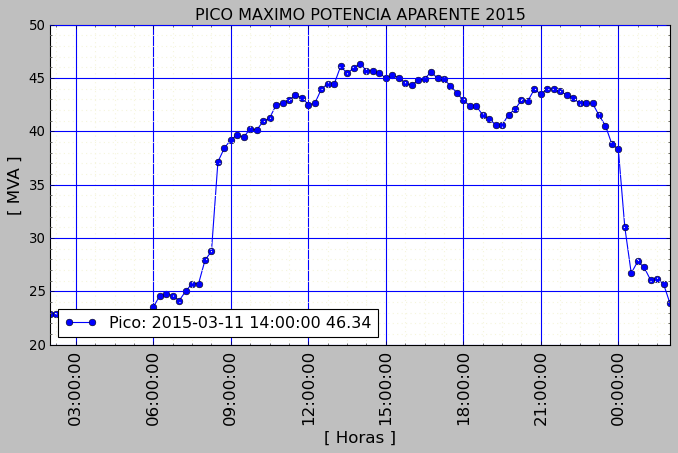

<Figure size 640x480 with 0 Axes>

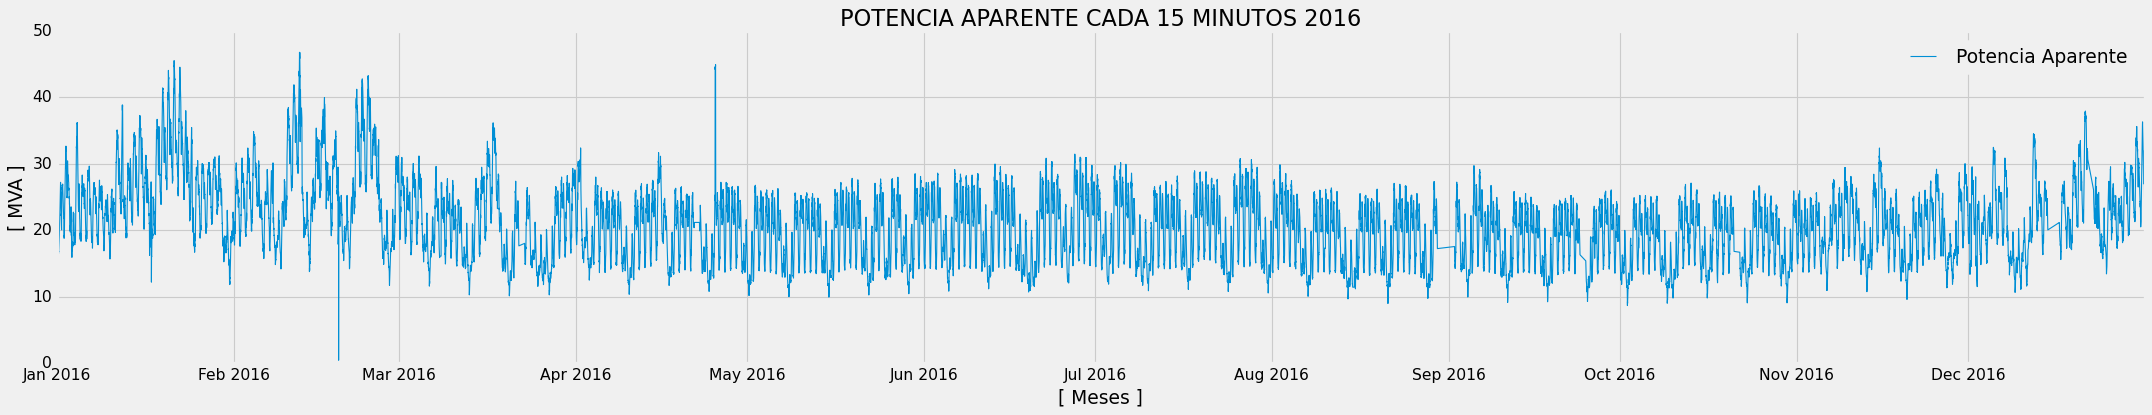

<Figure size 640x480 with 0 Axes>

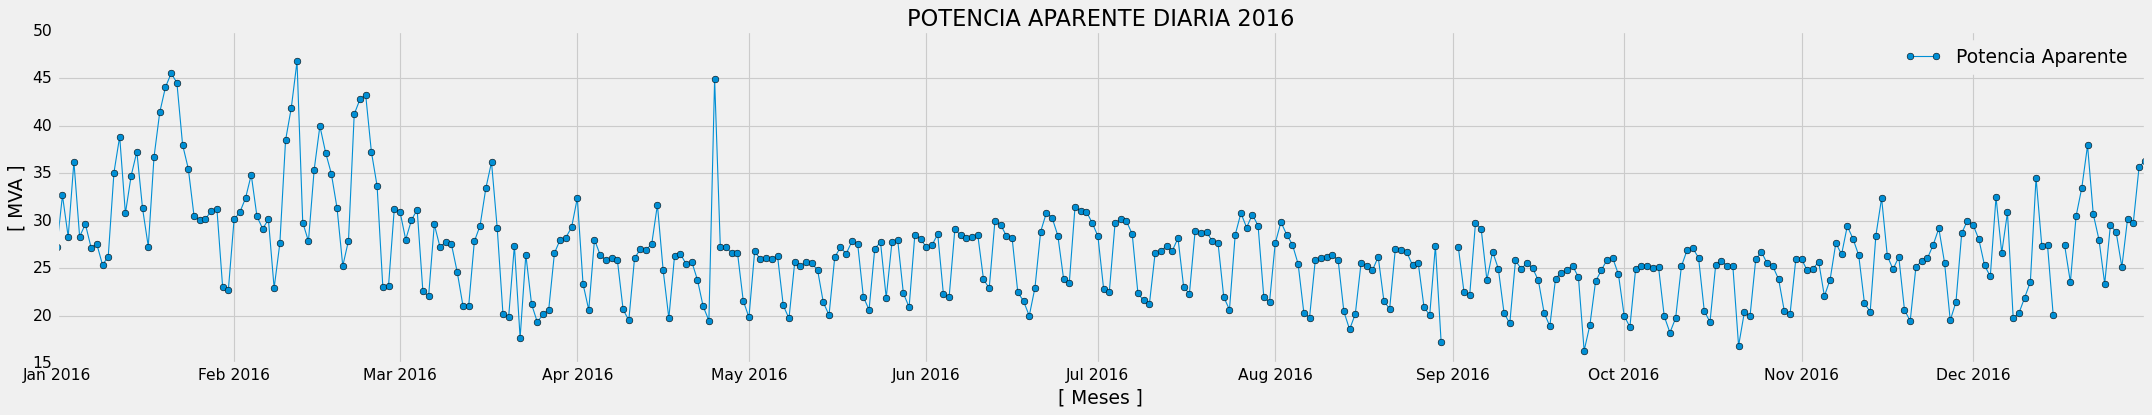

<Figure size 640x480 with 0 Axes>

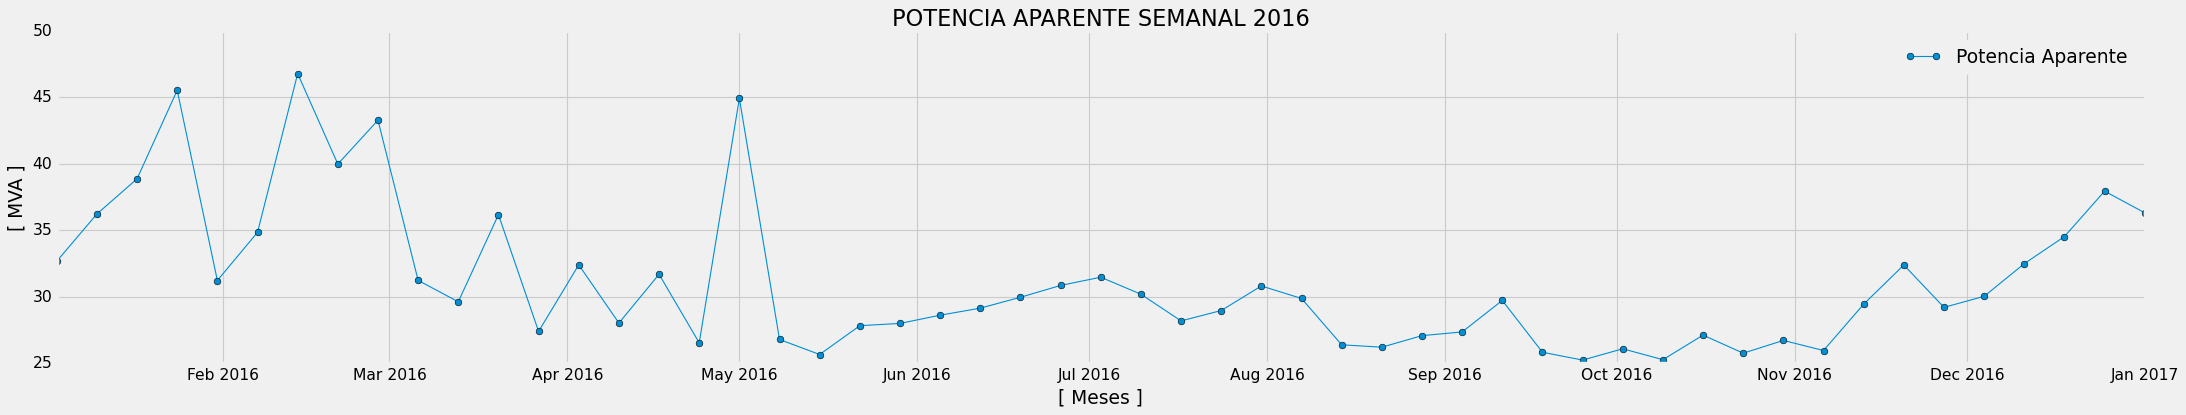

<Figure size 640x480 with 0 Axes>

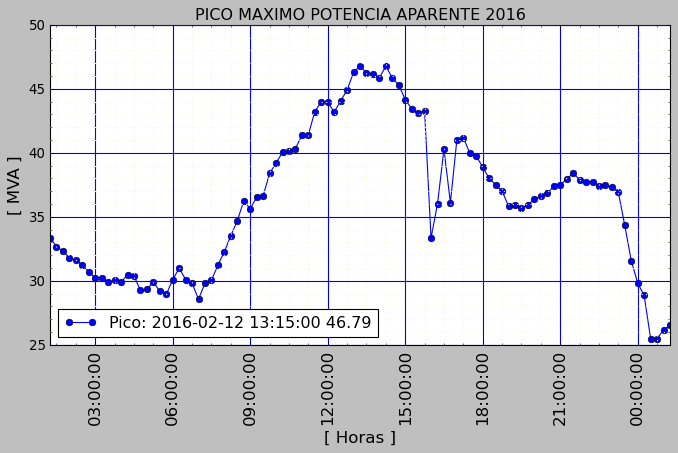

<Figure size 640x480 with 0 Axes>

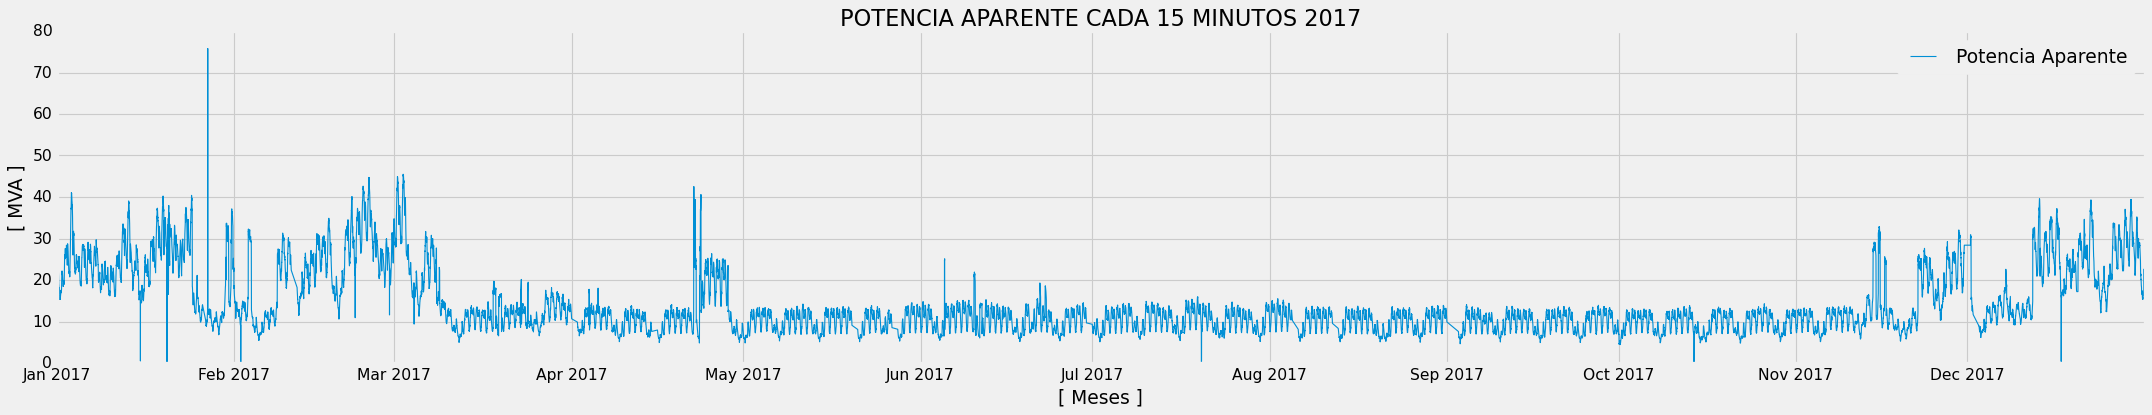

<Figure size 640x480 with 0 Axes>

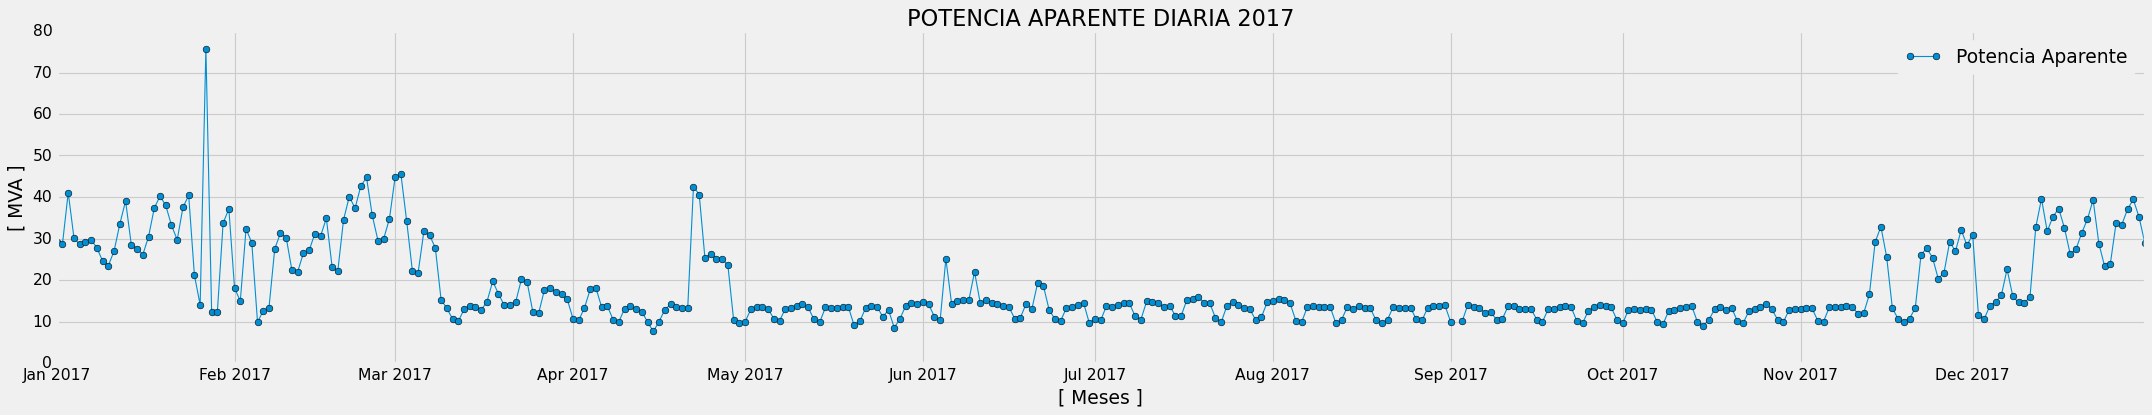

<Figure size 640x480 with 0 Axes>

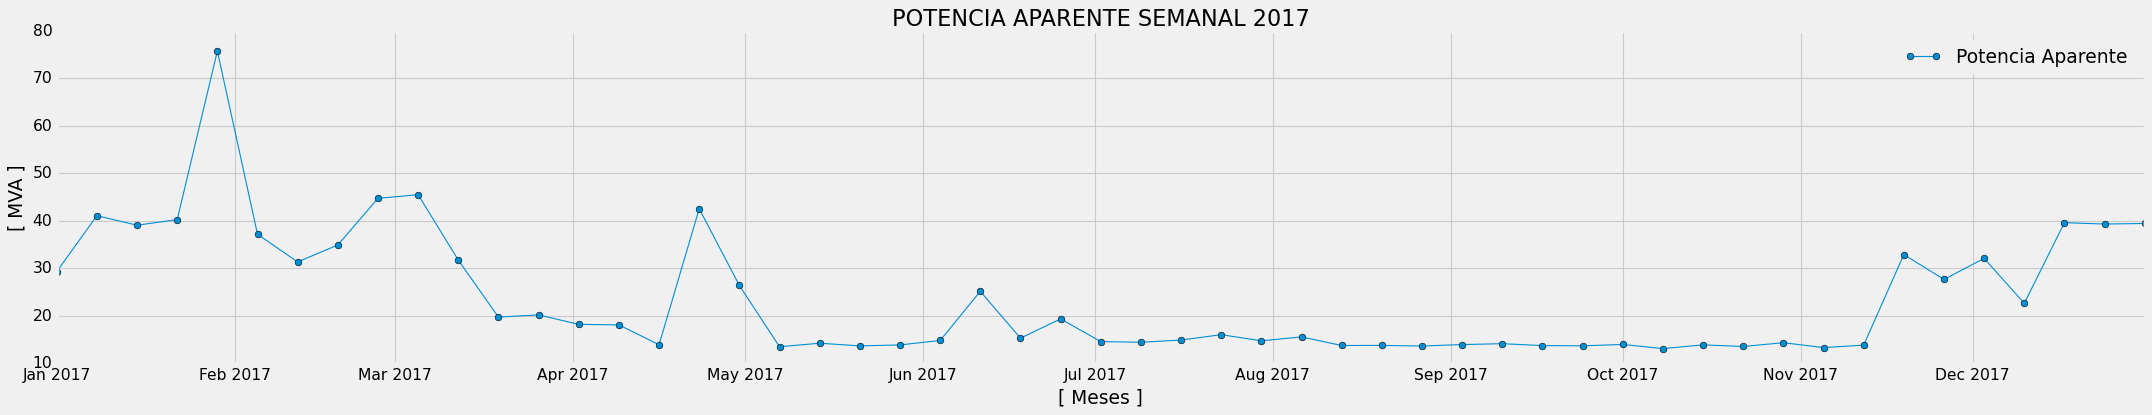

<Figure size 640x480 with 0 Axes>

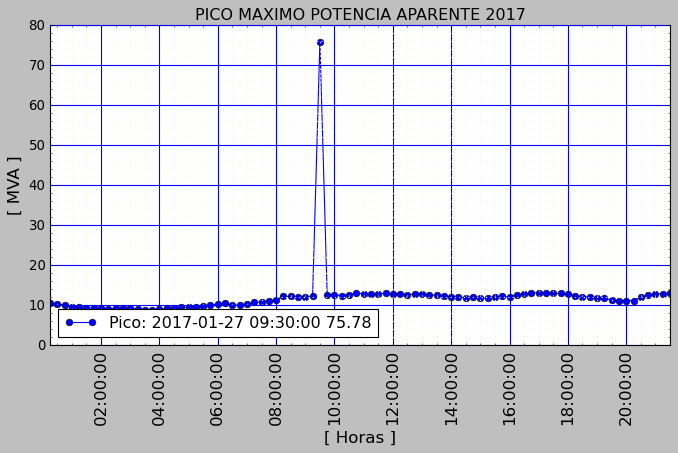

<Figure size 640x480 with 0 Axes>

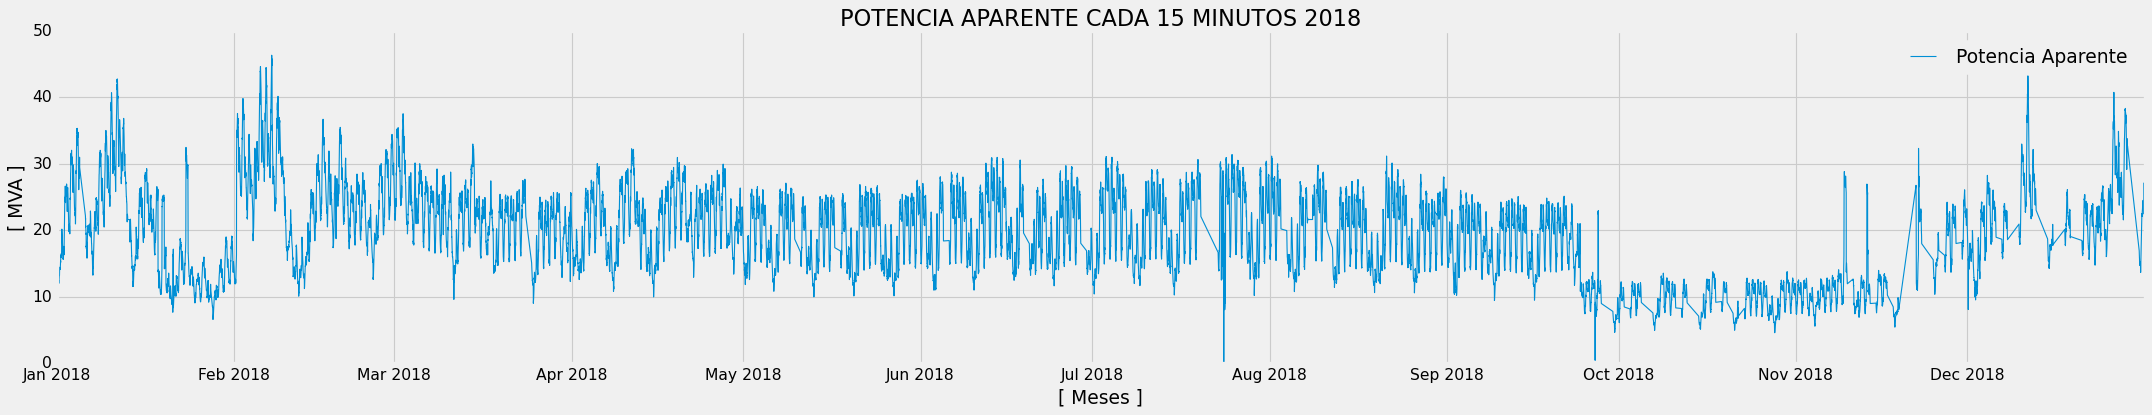

<Figure size 640x480 with 0 Axes>

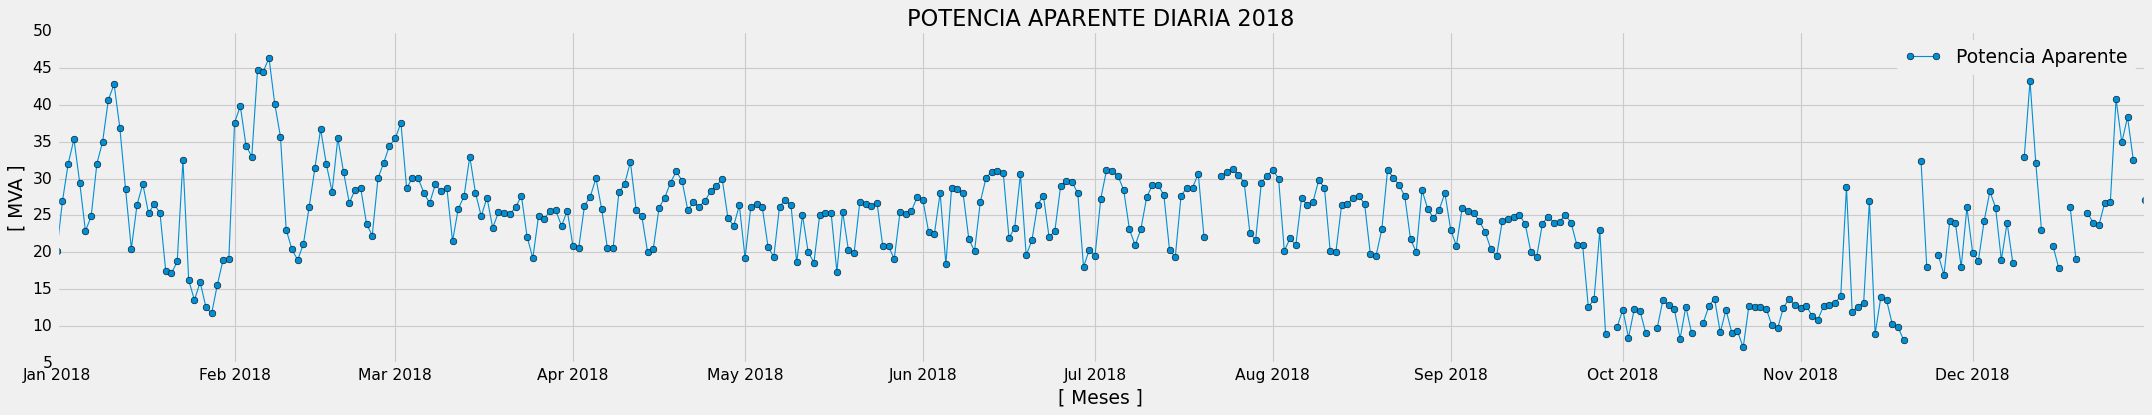

<Figure size 640x480 with 0 Axes>

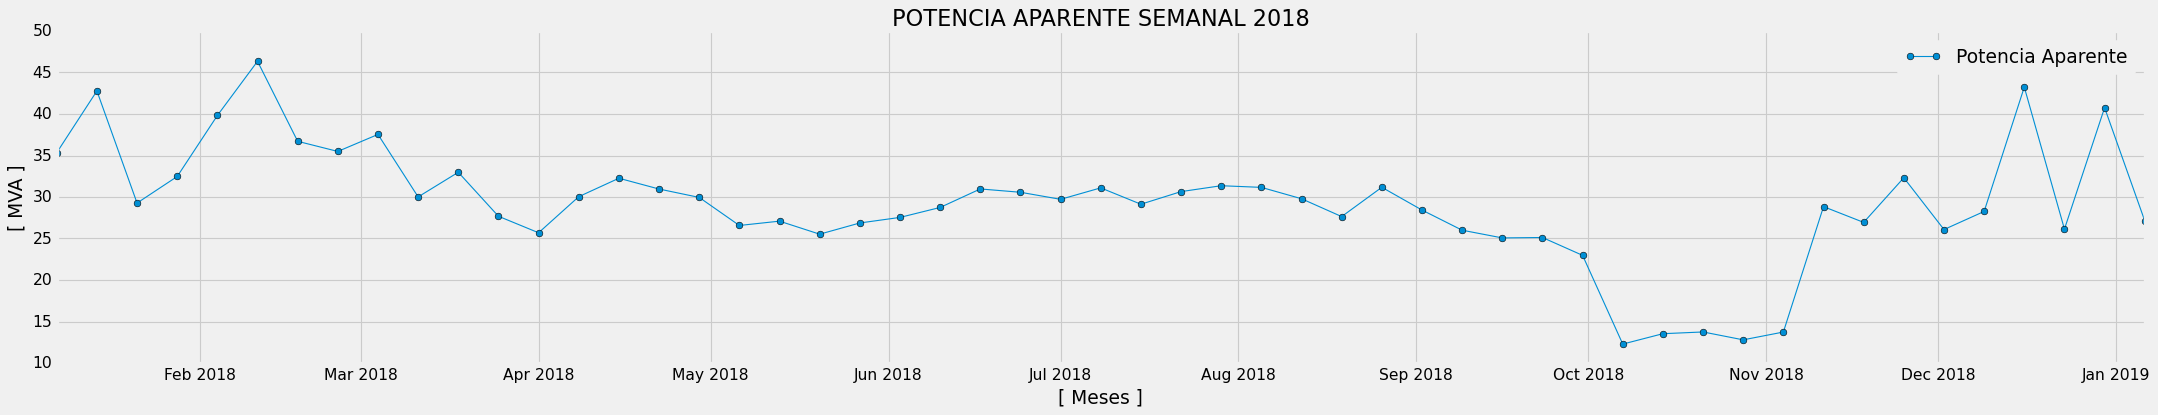

<Figure size 640x480 with 0 Axes>

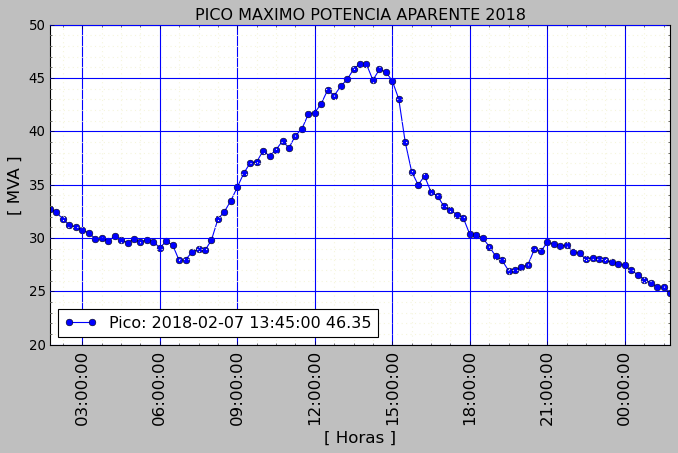

<Figure size 640x480 with 0 Axes>

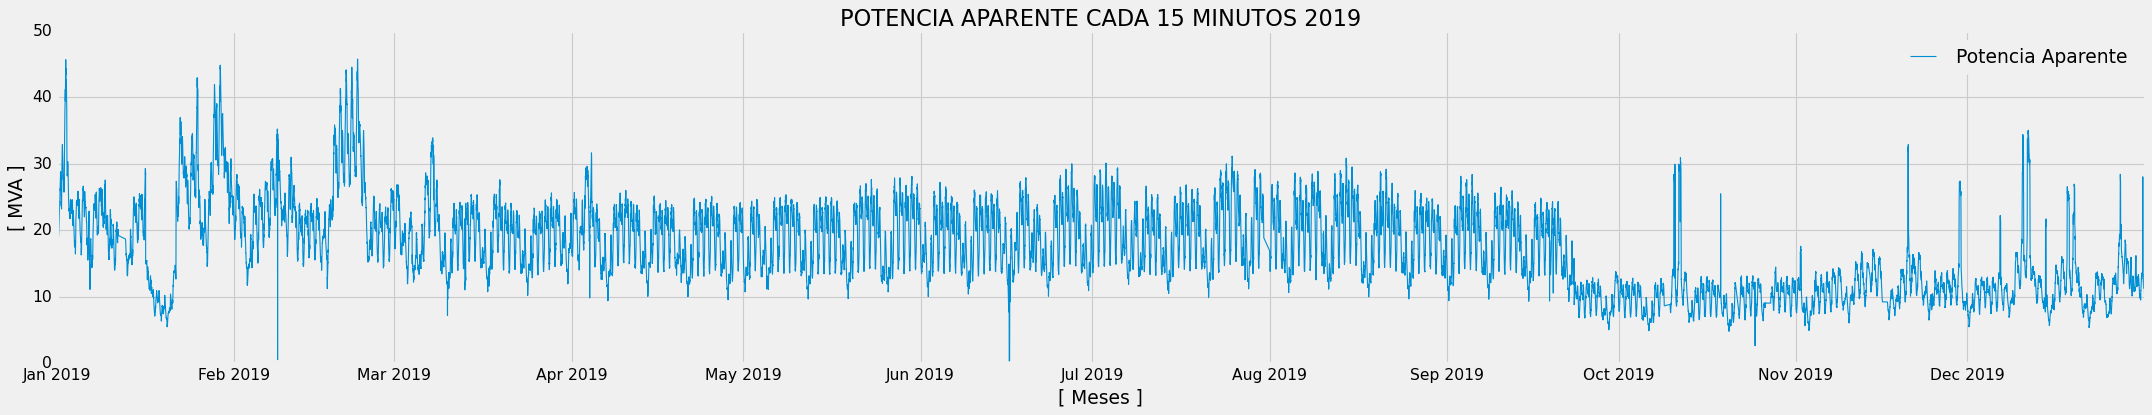

<Figure size 640x480 with 0 Axes>

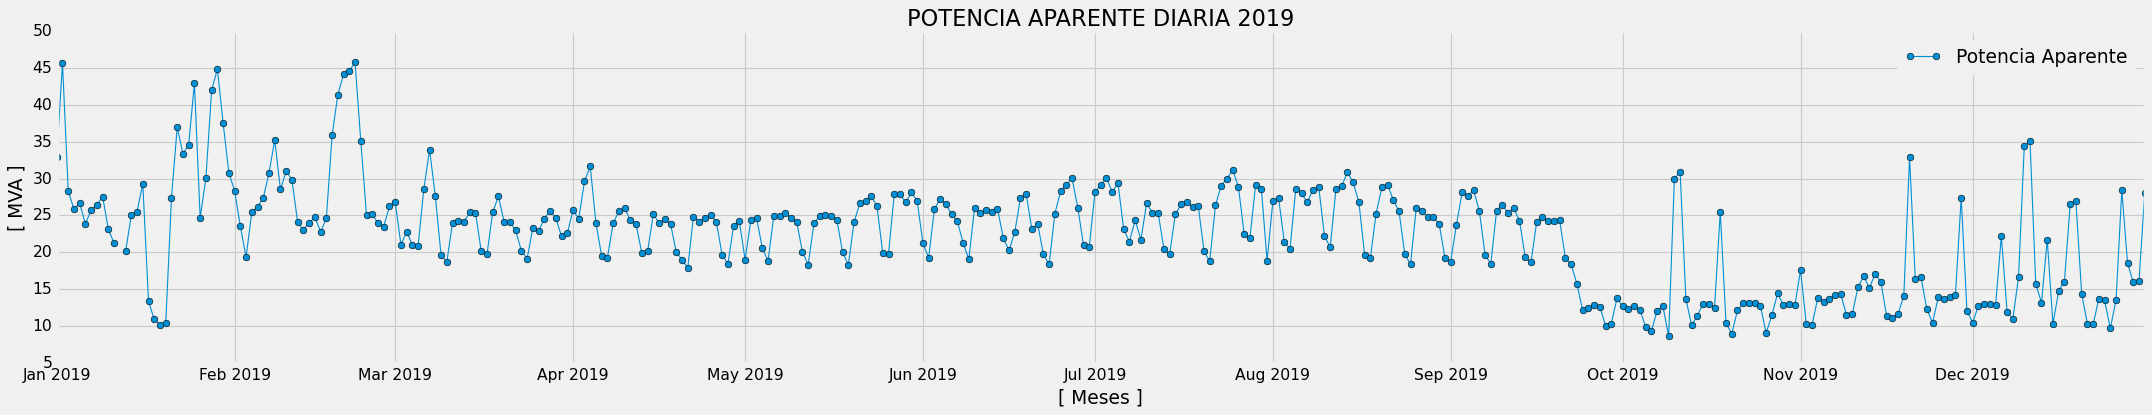

<Figure size 640x480 with 0 Axes>

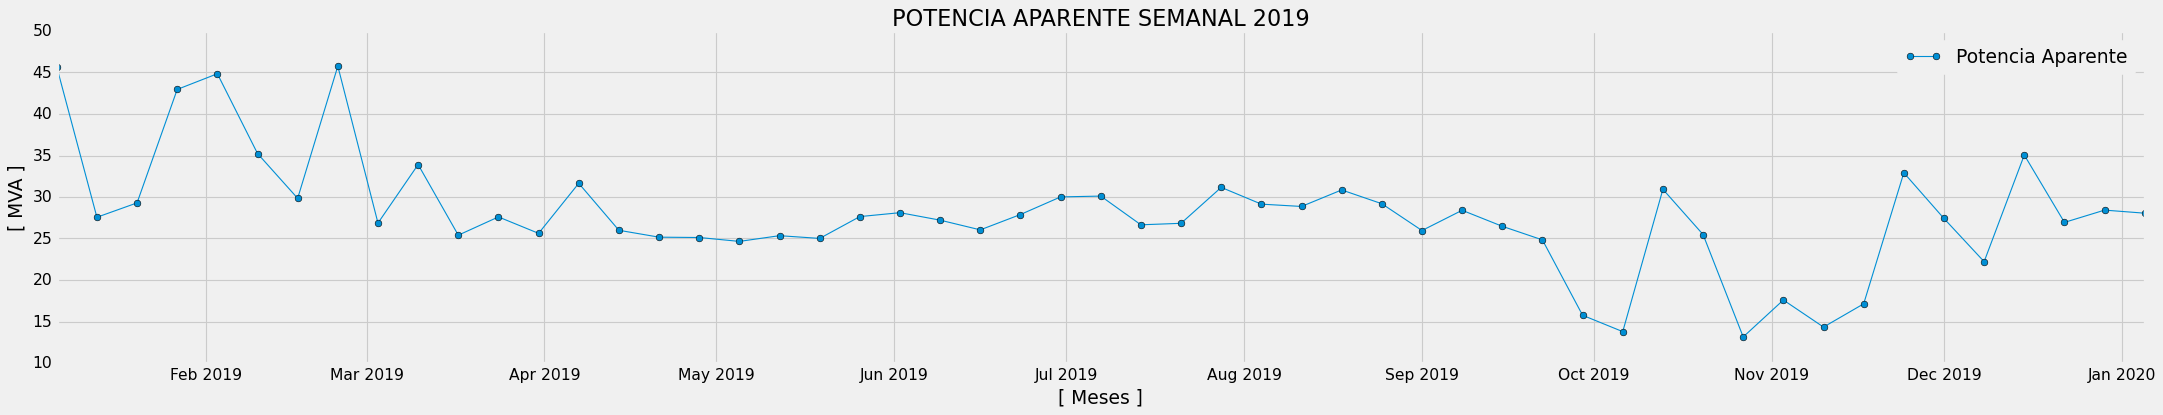

<Figure size 640x480 with 0 Axes>

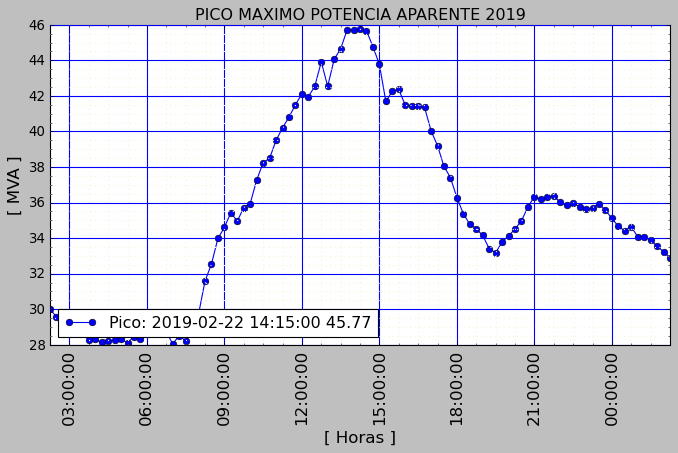

<Figure size 640x480 with 0 Axes>

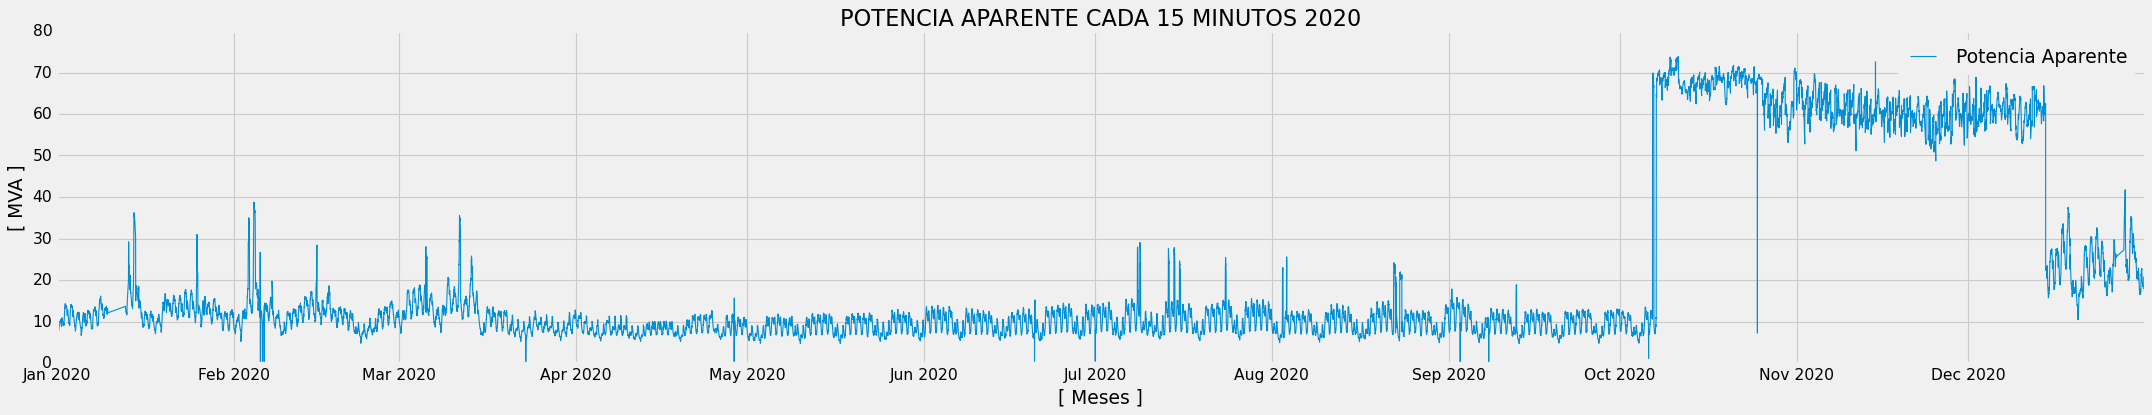

<Figure size 640x480 with 0 Axes>

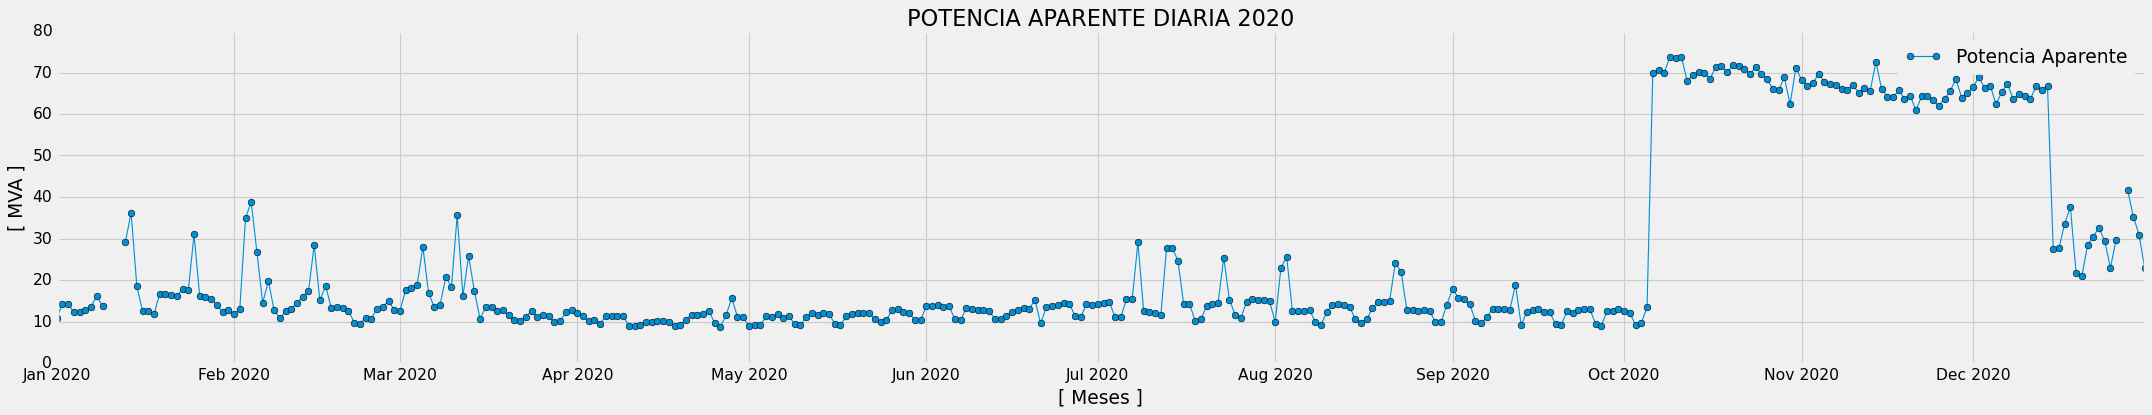

<Figure size 640x480 with 0 Axes>

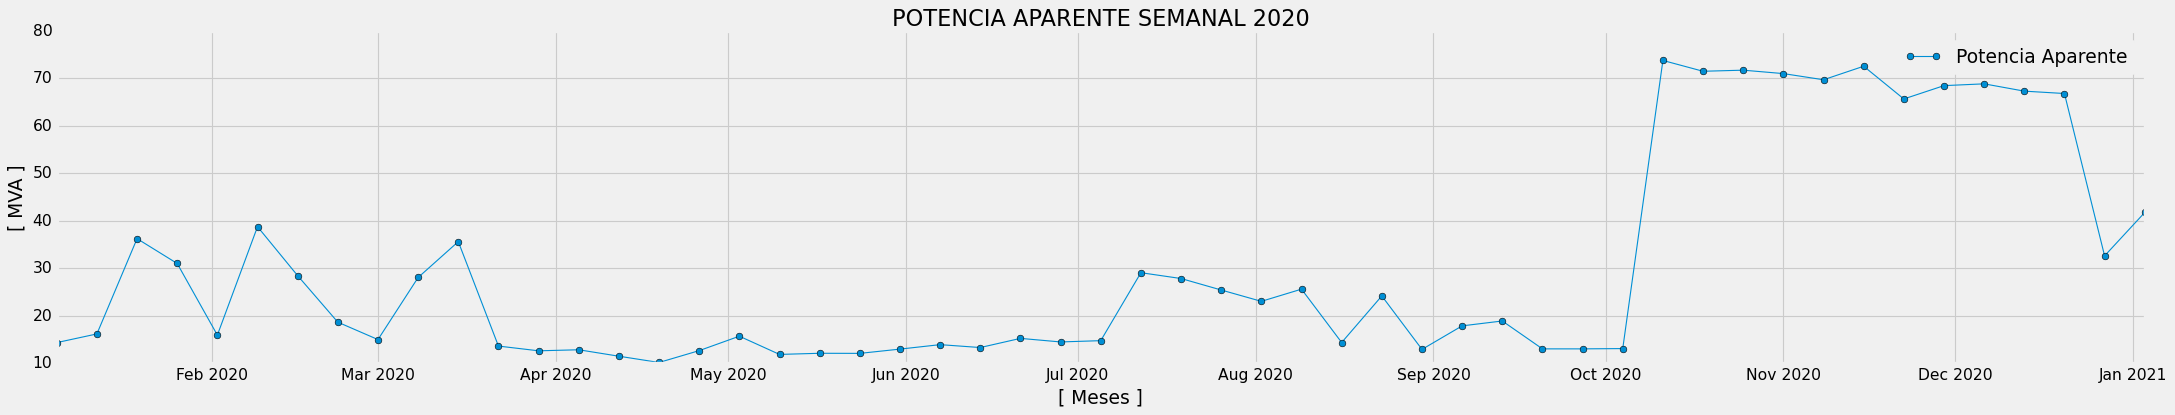

<Figure size 640x480 with 0 Axes>

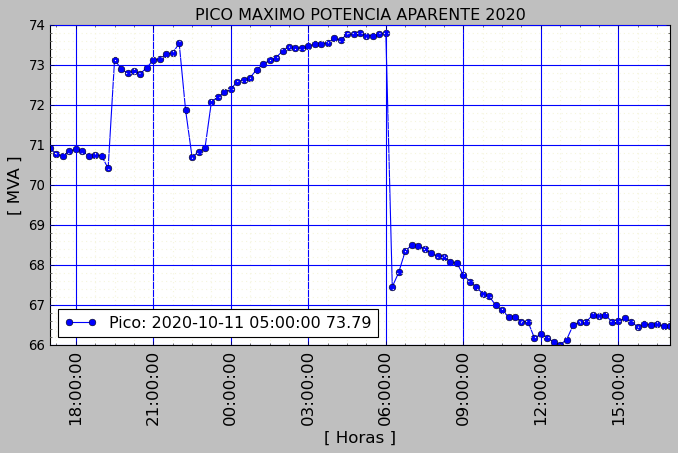

In [18]:
# LANZO LAS GRAFICAS 

Grafica_Todos_Anios_xSemana()

todos_anios = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

for anio in todos_anios:
    Grafica_Anual_15min(anio)
    Grafica_Anual_xDia(anio)
    Grafica_Anual_xSemana(anio)
    Grafica_Pico_Anual(anio)

### Borramos Datos Atipicos

In [19]:
#
# BORRO DATOS ATIPICOS

foto = datos.loc['2017-01-27 09:30:00':'2017-01-27 09:30:00'].index
datos = datos.drop(foto)

desde = '2020-10-06 17:15:00'
hasta = '2020-12-14 14:45:00'
indice = datos.loc[desde:hasta].index
datos = datos.drop(indice)


desde = pd. to_datetime(desde)
hasta = pd. to_datetime(hasta)
duracion = hasta - desde
print('Se borro: ', duracion, 'que equivale a tantas mediciones tomadas de a 15 min') 

Se borro:  68 days 21:30:00 que equivale a tantas mediciones tomadas de a 15 min


In [20]:
datos

Fecha   Hora    MW  MVAR   MVA
Fecha_Hora                                              
2010-01-01 00:15:00  01/01/2010  00:15 15.80 7.13  17.33
2010-01-01 00:30:00  01/01/2010  00:30 15.63 6.82  17.05
2010-01-01 00:45:00  01/01/2010  00:45 15.49 6.80  16.91
2010-01-01 01:00:00  01/01/2010  01:00 15.55 6.81  16.98
2010-01-01 01:15:00  01/01/2010  01:15 15.50 6.82  16.93
...                         ...    ...   ...  ...    ...
2020-12-31 22:45:00  31/12/2020  22:45 16.49 4.07  16.98
2020-12-31 23:00:00  31/12/2020  23:00 16.32 3.98  16.80
2020-12-31 23:15:00  31/12/2020  23:15 16.21 3.89  16.67
2020-12-31 23:30:00  31/12/2020  23:30 16.22 3.99  16.70
2020-12-31 23:45:00  31/12/2020  23:45 16.10 3.96  16.58

[370019 rows x 5 columns]

## Pronosticos

### Tabla Historica

In [83]:
# 
# GENERAR TABLA EXCEL CON LOS DATOS DEPURADOS
#
anios_hist = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

Trafos = pd.Series([25.0, 25.0, 25.0], index=['TD1', 'TD2', 'TD3'])
POT_INSTALADA = Trafos.sum()

Historica = pd.DataFrame(columns = ['FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA'])

for anio in anios_hist:
    #Anio = pd.to_numeric(anio)
    fecha_hora_i = datos.loc[anio:anio, 'MVA'].idxmax()
    maximo_p     = datos.loc[fecha_hora_i, 'MW'].max()
    maximo_q     = datos.loc[fecha_hora_i, 'MVAR'].max()
    maximo_s     = datos.loc[fecha_hora_i, 'MVA'].max()
    Historica.loc[anio] = [fecha_hora_i, maximo_p, maximo_q, maximo_s]  
    
# Columnas derivadas
Historica['POT_INSTALADA'] = POT_INSTALADA
Historica['CRECIMIENTO_%'] = Historica['S_MVA'].pct_change().mul(100)
Historica['N-1'] = Historica['POT_INSTALADA'] - Trafos.max()   
Historica['CARGA_%'] = Historica['S_MVA'] / Historica['POT_INSTALADA'] * 100
Historica['ANIO'] = pd.to_numeric(Historica.index)

nombres_columnas = ['ANIO', 'FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA', 'CRECIMIENTO_%', 'POT_INSTALADA', 'N-1', 'CARGA_%']
Historica = Historica.reindex(columns=nombres_columnas)
Historica

ANIO          FECHA_HORA  P_MW  Q_MVAR  S_MVA  CRECIMIENTO_%  \
2010  2010 2010-01-05 14:00:00 36.24 8.89    37.32  NaN              
2011  2011 2011-12-20 13:30:00 39.13 9.23    40.20  7.72             
2012  2012 2012-02-16 14:00:00 42.13 9.47    43.18  7.41             
2013  2013 2013-12-26 15:00:00 41.97 7.88    42.70  -1.11            
2014  2014 2014-01-23 14:00:00 48.67 10.21   49.73  16.46            
2015  2015 2015-03-11 14:00:00 44.64 12.43   46.34  -6.82            
2016  2016 2016-02-12 13:15:00 45.93 8.94    46.79  0.97             
2017  2017 2017-03-02 13:15:00 45.16 5.41    45.48  -2.80            
2018  2018 2018-02-07 13:45:00 46.22 3.40    46.35  1.91             
2019  2019 2019-02-22 14:15:00 45.63 3.57    45.77  -1.25            
2020  2020 2020-12-28 13:15:00 41.71 1.59    41.74  -8.80            

      POT_INSTALADA   N-1  CARGA_%  
2010 75.00          50.00 49.76     
2011 75.00          50.00 53.60     
2012 75.00          50.00 57.57     
2013 75.00          50.00 56.93     
2014 75.00          50.00 66.31     
2015 75.00          50.00 61.79     
2016 75.00          50.00 62.39     
2017 75.00          50.00 60.64     
2018 75.00          50.00 61.80     
2019 75.00          50.00 61.03     
2020 75.00          50.00 55.65

In [84]:
Historica.index

Index(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020'],
      dtype='object')

### Regresion Lineal

In [85]:
pd.set_option('display.float_format', '{:.8f}'.format)
import statsmodels.formula.api as smf
lm = smf.ols(formula="S_MVA~ANIO", data = Historica).fit()
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Ordinary least squares
================================================================
Model:              OLS              Adj. R-squared:     0.151  
Dependent Variable: S_MVA            AIC:                58.8403
Date:               2021-12-01 11:58 BIC:                59.6361
No. Observations:   11               Log-Likelihood:     -27.420
Df Model:           1                F-statistic:        2.773  
Df Residuals:       9                Prob (F-statistic): 0.130  
R-squared:          0.236            Scale:              10.467 
----------------------------------------------------------------
             Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
----------------------------------------------------------------
Intercept  -991.0150 621.5848 -1.5943 0.1453 -2397.1375 415.1075
ANIO          0.5137   0.3085  1.6654 0.1302    -0.1841   1.2116
----------------------------------------------------------------
Omnibus:             0.658       Durbin-Watson:          1.016  
Prob(Omnibus):       0.719       Jarque-Bera (JB):       0.041  
Skew:                0.147       Prob(JB):               0.980  
Kurtosis:            2.950       Condition No.:          1283959
================================================================
* The condition number is large (1e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

In [87]:
pd.set_option('display.float_format', '{:.2f}'.format)

Historica['S_MVA_PRED'] = lm.predict(Historica['ANIO'])

nombres_columnas = ['ANIO', 'FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA', 'CRECIMIENTO_%', 'S_MVA_PRED', 'POT_INSTALADA', 'N-1', 'CARGA_%']
Historica = Historica.reindex(columns=nombres_columnas)
Historica

ANIO          FECHA_HORA  P_MW  Q_MVAR  S_MVA  CRECIMIENTO_%  \
2010  2010 2010-01-05 14:00:00 36.24 8.89    37.32  NaN              
2011  2011 2011-12-20 13:30:00 39.13 9.23    40.20  7.72             
2012  2012 2012-02-16 14:00:00 42.13 9.47    43.18  7.41             
2013  2013 2013-12-26 15:00:00 41.97 7.88    42.70  -1.11            
2014  2014 2014-01-23 14:00:00 48.67 10.21   49.73  16.46            
2015  2015 2015-03-11 14:00:00 44.64 12.43   46.34  -6.82            
2016  2016 2016-02-12 13:15:00 45.93 8.94    46.79  0.97             
2017  2017 2017-03-02 13:15:00 45.16 5.41    45.48  -2.80            
2018  2018 2018-02-07 13:45:00 46.22 3.40    46.35  1.91             
2019  2019 2019-02-22 14:15:00 45.63 3.57    45.77  -1.25            
2020  2020 2020-12-28 13:15:00 41.71 1.59    41.74  -8.80            

      S_MVA_PRED  POT_INSTALADA   N-1  CARGA_%  
2010 41.58       75.00          50.00 49.76     
2011 42.09       75.00          50.00 53.60     
2012 42.60       75.00          50.00 57.57     
2013 43.12       75.00          50.00 56.93     
2014 43.63       75.00          50.00 66.31     
2015 44.15       75.00          50.00 61.79     
2016 44.66       75.00          50.00 62.39     
2017 45.17       75.00          50.00 60.64     
2018 45.69       75.00          50.00 61.80     
2019 46.20       75.00          50.00 61.03     
2020 46.71       75.00          50.00 55.65

In [73]:
print('Parametros : ', lm.params) 
print('R2 : ', lm.rsquared)

Parametros :  Intercept   -991.01500000
ANIO        0.51372727   
dtype: float64
R2 :  0.23556622997556143


### Tabla de Pronosticos

In [88]:
#
#  AGREGO LOS AÑOS DE PRONOSTICO PROPIAMENTE DICHO
#
#Pronostico  = Tablaxls.copy()
pd.set_option('display.float_format', '{:.2f}'.format)
anios_pro = ['2021', '2022', '2023', '2024', '2025', '2026']
POT_INSTALADA = Trafos.sum()
Precaucion    = POT_INSTALADA - Trafos.max()

Anio = pd.Series(pd.to_numeric(anios_pro), index=anios_pro)
Fecha_Hora = pd.Series(np.nan, index= anios_pro)
P_MW   = pd.Series(np.nan, index=anios_pro)
Q_MVAR = pd.Series(np.nan, index=anios_pro)
S_MVA  = pd.Series(np.nan, index=anios_pro)
Crecimiento = pd.Series(np.nan, index=anios_pro)

Pronostico = pd.DataFrame({'ANIO':Anio, 
                           'FECHA_HORA':Fecha_Hora, 
                           'P_MW':P_MW, 
                           'Q_MVAR':Q_MVAR,
                           'S_MVA':S_MVA,
                           'CRECIMIENTO_%':Crecimiento}, index=anios_pro)

# El MODELO DE REGRESION LINEAL         
Pronostico['S_MVA_PRED'] = 0.51372727*Pronostico["ANIO"] - 991.015000
#
Pronostico['POT_INSTALADA'] = POT_INSTALADA
Pronostico['N-1'] = Pronostico['POT_INSTALADA'] - Trafos.max()  
Pronostico['CARGA_%'] = Pronostico['S_MVA_PRED'] / Pronostico['POT_INSTALADA'] * 100 

# nombres_columnas = ['FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA', 'Crecimiento %', 'Pot_Instalada', 'N-1', '% Carga']
#Tablaxls = Tablaxls.reindex(columns=nombres_columnas)

Pronostico

ANIO  FECHA_HORA  P_MW  Q_MVAR  S_MVA  CRECIMIENTO_%  S_MVA_PRED  \
2021  2021 NaN         NaN   NaN     NaN    NaN            47.23         
2022  2022 NaN         NaN   NaN     NaN    NaN            47.74         
2023  2023 NaN         NaN   NaN     NaN    NaN            48.26         
2024  2024 NaN         NaN   NaN     NaN    NaN            48.77         
2025  2025 NaN         NaN   NaN     NaN    NaN            49.28         
2026  2026 NaN         NaN   NaN     NaN    NaN            49.80         

      POT_INSTALADA   N-1  CARGA_%  
2021 75.00          50.00 62.97     
2022 75.00          50.00 63.66     
2023 75.00          50.00 64.34     
2024 75.00          50.00 65.03     
2025 75.00          50.00 65.71     
2026 75.00          50.00 66.40

In [92]:
#
# CONCATENAR LA TABLA HISTORICA + TABLA PRONOSTICO
#
Tablaxls = pd.concat([Historica,Pronostico], axis = 0)
Tablaxls

ANIO          FECHA_HORA  P_MW  Q_MVAR  S_MVA  CRECIMIENTO_%  \
2010  2010 2010-01-05 14:00:00 36.24 8.89    37.32  NaN              
2011  2011 2011-12-20 13:30:00 39.13 9.23    40.20  7.72             
2012  2012 2012-02-16 14:00:00 42.13 9.47    43.18  7.41             
2013  2013 2013-12-26 15:00:00 41.97 7.88    42.70  -1.11            
2014  2014 2014-01-23 14:00:00 48.67 10.21   49.73  16.46            
2015  2015 2015-03-11 14:00:00 44.64 12.43   46.34  -6.82            
2016  2016 2016-02-12 13:15:00 45.93 8.94    46.79  0.97             
2017  2017 2017-03-02 13:15:00 45.16 5.41    45.48  -2.80            
2018  2018 2018-02-07 13:45:00 46.22 3.40    46.35  1.91             
2019  2019 2019-02-22 14:15:00 45.63 3.57    45.77  -1.25            
2020  2020 2020-12-28 13:15:00 41.71 1.59    41.74  -8.80            
2021  2021 NaT                 NaN   NaN     NaN    NaN              
2022  2022 NaT                 NaN   NaN     NaN    NaN              
2023  2023 NaT                 NaN   NaN     NaN    NaN              
2024  2024 NaT                 NaN   NaN     NaN    NaN              
2025  2025 NaT                 NaN   NaN     NaN    NaN              
2026  2026 NaT                 NaN   NaN     NaN    NaN              

      S_MVA_PRED  POT_INSTALADA   N-1  CARGA_%  
2010 41.58       75.00          50.00 49.76     
2011 42.09       75.00          50.00 53.60     
2012 42.60       75.00          50.00 57.57     
2013 43.12       75.00          50.00 56.93     
2014 43.63       75.00          50.00 66.31     
2015 44.15       75.00          50.00 61.79     
2016 44.66       75.00          50.00 62.39     
2017 45.17       75.00          50.00 60.64     
2018 45.69       75.00          50.00 61.80     
2019 46.20       75.00          50.00 61.03     
2020 46.71       75.00          50.00 55.65     
2021 47.23       75.00          50.00 62.97     
2022 47.74       75.00          50.00 63.66     
2023 48.26       75.00          50.00 64.34     
2024 48.77       75.00          50.00 65.03     
2025 49.28       75.00          50.00 65.71     
2026 49.80       75.00          50.00 66.40

### Graficas al 2026

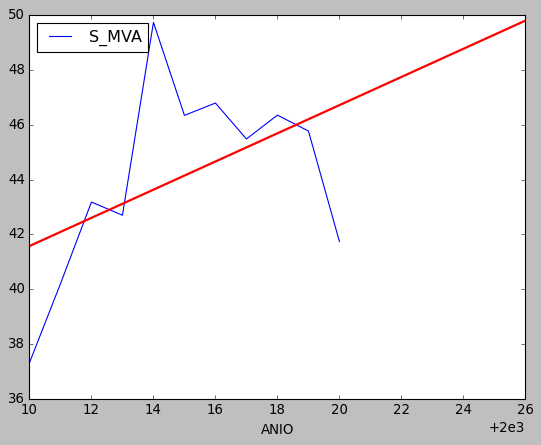

In [96]:
Tablaxls.plot(kind = "line", x = "ANIO", y ="S_MVA")
plt.plot(Tablaxls["ANIO"], Tablaxls['S_MVA_PRED'], c="red", linewidth = 2)

In [143]:
# Grafica anual de la Potencia Aparente cada 15 minutos

def Grafica_Hist_Pred():
    plt.style.use('fivethirtyeight')
    
    
    y = Tablaxls.loc['2010':'2020', 'S_MVA']
    x_y = Tablaxls.loc['2010':'2020', 'ANIO']
    
    pred = Tablaxls.loc[:, 'S_MVA_PRED']
    x_pred = Tablaxls.loc[:, 'ANIO']
    
    p_inst = Tablaxls.loc[:, 'POT_INSTALADA']
    precau = Tablaxls.loc[:, 'N-1']
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(10, 5))
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(x_y, y, lw=3, label='Pot. Aparente Hist', marker='o', color='k')
    grafico.plot(x_pred, pred, lw=3, label='Tendencia Lineal', marker='o', linestyle='dotted', color='g')
    grafico.plot(x_pred, p_inst, lw=3, label='Pot.Instalada', color='r')
    grafico.plot(x_pred, precau, lw=3, label='Precaucion N-1', color='y')
    
    grafico.set_ylim ([20,80])
    
    grafico.set_xlabel('[ Años ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("ET San Francisco: Demanda Historica y Pronostico al 2026")  # Add a title to the axes.
    grafico.legend(loc='lower right')  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid() 
    
    #fig.savefig("Serie_Anual_15min_"+anio+".png")

<Figure size 640x480 with 0 Axes>

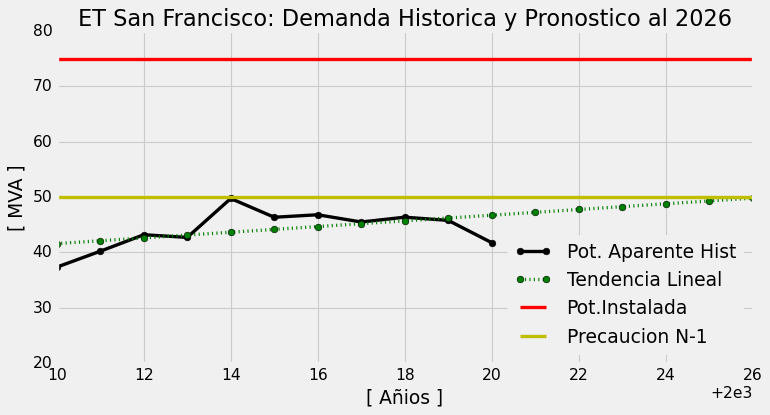

In [144]:
Grafica_Hist_Pred()

In [ ]:
Tablaxls["RSE"] = (Tablaxls["S_MVA"]-Tablaxls["S_MVA_pred"])**2
Tablaxls

(array([2., 0., 1., 0., 3., 2., 2., 0., 0., 1.]),
 array([-4.97409091, -3.86685455, -2.75961818, -1.65238182, -0.54514545,
         0.56209091,  1.66932727,  2.77656364,  3.8838    ,  4.99103636,
         6.09827273]),
 <BarContainer object of 10 artists>)

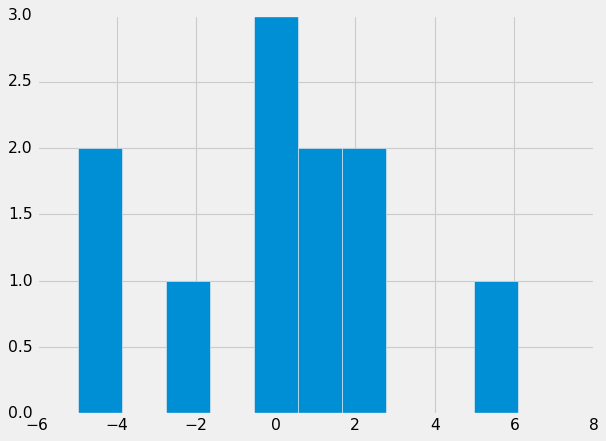

In [103]:
plt.hist((Tablaxls["S_MVA"]-Tablaxls["S_MVA_PRED"]))

In [100]:
Tablaxls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 2010 to 2026
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ANIO           17 non-null     int64         
 1   FECHA_HORA     11 non-null     datetime64[ns]
 2   P_MW           11 non-null     float64       
 3   Q_MVAR         11 non-null     float64       
 4   S_MVA          11 non-null     float64       
 5   CRECIMIENTO_%  10 non-null     float64       
 6   S_MVA_PRED     17 non-null     float64       
 7   POT_INSTALADA  17 non-null     float64       
 8   N-1            17 non-null     float64       
 9   CARGA_%        17 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.0+ KB


## Conclusiones